# Business Analytics and Data Science


# Final Assignment Winter 2020/2021


# by Maximilian Suliga,
# Student-ID: 616520
# Mail: suligama@hu-berlin.de

# Introduction

E-Commerce has long been said to be the future of retailing and the pandemic related to Covid-19 has undoubtly accelareted the shift from on-site to online shopping. Although a new concept of ordering online and picking up on-site has emerged during the course of the pandemic, "traditional" e-commerce has always been linked to shipping products to the customer. Many countries require firms to have a refund policy and companies have started to use this refund policy in combination with free shipping as a purchase incentive. 

One of the pioneers of this marketing approach is the online fashion retailer Zalando. Till this day the company offers free shipping and free returns including the shipping of returns for 100 days after the purchase, no matter what product or how expensive the whole order is. Other big online retailers like ASOS for the fashion industry and Amazon for e-commerce in general have similar policies, all enabling orders that are shipped and returned back completely for no additional costs to the customer.
 
Since the customer does not pay for the shippings, it is the company that takes the responsibility and hence all the costs. Returns are particularly costly, as they generate no revenue, exhaust two shippings, and are typically also linked to some kind of impairment of the products that were shipped. Knowing which orders will be returned and which will not is therefore of critical advantage for a company in order to minimize returns and its related costs.

With more transactions occuring online, more and more data is being generated. Extracting the information hidden in this data may be the key for achieving a competitive advantage, like the prediction of returns in online-sales. This notebook demonstrates the underlying work behind the prediction of returns using the data from previous orders of an online-shop that have already been kept or returned. The code used is Python together with a number of libraries.

# Explanatory Data Analysis

Before working with the data, it is recommended to have a look at it first. Apart from getting some sort of feeling of the data, some inconsistencies or outliers may already be detected alone from eye-balling. Although not restricted to it, data is typically not in the form required for a model to be properly used. Any kind of inconsistencies are to be expected as a consequence. Furthermore, it is also likely to not have all possible features given from the start. Some features need to be extracted first from the raw data, as will be done in the later section.

In [382]:
import numpy as np
import pandas as pd

In [383]:
from google.colab import files
uploaded = files.upload()
import io
  
df_known = pd.read_csv(io.BytesIO(uploaded['BADS_WS2021_known.csv']), index_col='order_item_id')

Saving BADS_WS2021_known.csv to BADS_WS2021_known (5).csv


In [384]:
df_known.info()
df_known

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100000 entries, 1 to 100000
Data columns (total 13 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   order_date     100000 non-null  object 
 1   delivery_date  90682 non-null   object 
 2   item_id        100000 non-null  int64  
 3   item_size      100000 non-null  object 
 4   item_color     100000 non-null  object 
 5   brand_id       100000 non-null  int64  
 6   item_price     100000 non-null  float64
 7   user_id        100000 non-null  int64  
 8   user_title     100000 non-null  object 
 9   user_dob       91275 non-null   object 
 10  user_state     100000 non-null  object 
 11  user_reg_date  100000 non-null  object 
 12  return         100000 non-null  int64  
dtypes: float64(1), int64(4), object(8)
memory usage: 10.7+ MB


,order_date,delivery_date,item_id,item_size,item_color,brand_id,item_price,user_id,user_title,user_dob,user_state,user_reg_date,return
order_item_id,,,,,,,,,,,,,
1,2016-06-22,2016-06-27,643,38,navy,30,49.90,30822,Mrs,1969-04-17,Saxony,2016-06-23,0
2,2016-06-22,NaN,337,152,grey,30,19.95,30822,Mrs,1969-04-17,Saxony,2016-06-23,0
3,2016-06-22,2016-06-27,270,xxl,grey,49,79.90,30823,Mrs,1970-04-22,Baden-Wuerttemberg,2015-03-15,1
4,2016-06-22,2016-06-27,142,xxl,grey,49,99.90,30823,Mrs,1970-04-22,Baden-Wuerttemberg,2015-03-15,0
5,2016-06-22,2016-06-27,561,xxl,grey,3,14.90,30823,Mrs,1970-04-22,Baden-Wuerttemberg,2015-03-15,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
99996,2016-09-11,2016-09-12,156,20,blue,34,29.90,713,Mrs,1959-03-21,Rhineland-Palatinate,2015-02-17,0
99997,2016-09-11,2016-09-12,156,20,brown,34,29.90,713,Mrs,1959-03-21,Rhineland-Palatinate,2015-02-17,0
99998,2016-09-11,1994-12-31,1832,xxl,black,37,26.90,47794,Mr,1985-03-01,Hamburg,2016-09-10,0


As can be seen above, the data consists of 13 variables and 100,000 orders. The first table gives insight about whether there are any missing values, the datatype of each variable and the overall memory used. As shown, the variables delivery_date and user_dob (date of birth) contain missing values. Further, many variables are saved under the object-datatype. This is an automatic result coming from Python saving variables that contain string characters as objects by default. Item_price is saved as a float64, which means it contains numbers that do not only consist of integers. All other variables contain only integers and are saved as int64.

The display of the known dataframe gives some additional insight in what is contained in each variable. For example, it can be seen that item_size contains very different, barely comparable sizes like xxl and 20. The target variable return seems to consist only of 1s and 0s.

In [385]:
df_known.describe(include = 'all') #displays variables instead of only the numerical ones

,order_date,delivery_date,item_id,item_size,item_color,brand_id,item_price,user_id,user_title,user_dob,user_state,user_reg_date,return
count,100000,90682,100000.000000,100000,100000,100000.000000,100000.000000,100000.000000,100000,91275,100000,100000,100000.000000
unique,82,123,NaN,102,77,NaN,NaN,NaN,5,9247,16,573,NaN
top,2016-06-27,2016-07-03,NaN,l,black,NaN,NaN,NaN,Mrs,1900-11-21,North Rhine-Westphalia,2015-02-17,NaN
freq,5577,5061,NaN,12347,18640,NaN,NaN,NaN,95429,919,22825,33966,NaN
mean,NaN,NaN,923.781820,NaN,NaN,30.149020,65.064695,27169.073960,NaN,NaN,NaN,NaN,0.458180
std,NaN,NaN,702.568822,NaN,NaN,28.180191,47.991546,14053.417669,NaN,NaN,NaN,NaN,0.498251
min,NaN,NaN,1.000000,NaN,NaN,1.000000,0.000000,9.000000,NaN,NaN,NaN,NaN,0.000000
25%,NaN,NaN,214.000000,NaN,NaN,5.000000,29.900000,14937.000000,NaN,NaN,NaN,NaN,0.000000
50%,NaN,NaN,812.000000,NaN,NaN,25.000000,49.900000,31189.000000,NaN,NaN,NaN,NaN,0.000000
75%,NaN,NaN,1581.000000,NaN,NaN,44.000000,79.900000,38917.250000,NaN,NaN,NaN,NaN,1.000000


The describe command above gives further insight into the variables. Particularly, it shows the smallest and biggest value of a numerical value. It will be of greater use when variables are adjusted and new variables generated, which will be done in the following Data Preparation part.

The isnull command below summarizes seperately the missing values in the dataset.

In [386]:
df_known.isnull().sum()

order_date          0
delivery_date    9318
item_id             0
item_size           0
item_color          0
brand_id            0
item_price          0
user_id             0
user_title          0
user_dob         8725
user_state          0
user_reg_date       0
return              0
dtype: int64

# Data Preparation



##Remove Duplicates

In [387]:
df_known

,order_date,delivery_date,item_id,item_size,item_color,brand_id,item_price,user_id,user_title,user_dob,user_state,user_reg_date,return
order_item_id,,,,,,,,,,,,,
1,2016-06-22,2016-06-27,643,38,navy,30,49.90,30822,Mrs,1969-04-17,Saxony,2016-06-23,0
2,2016-06-22,NaN,337,152,grey,30,19.95,30822,Mrs,1969-04-17,Saxony,2016-06-23,0
3,2016-06-22,2016-06-27,270,xxl,grey,49,79.90,30823,Mrs,1970-04-22,Baden-Wuerttemberg,2015-03-15,1
4,2016-06-22,2016-06-27,142,xxl,grey,49,99.90,30823,Mrs,1970-04-22,Baden-Wuerttemberg,2015-03-15,0
5,2016-06-22,2016-06-27,561,xxl,grey,3,14.90,30823,Mrs,1970-04-22,Baden-Wuerttemberg,2015-03-15,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
99996,2016-09-11,2016-09-12,156,20,blue,34,29.90,713,Mrs,1959-03-21,Rhineland-Palatinate,2015-02-17,0
99997,2016-09-11,2016-09-12,156,20,brown,34,29.90,713,Mrs,1959-03-21,Rhineland-Palatinate,2015-02-17,0
99998,2016-09-11,1994-12-31,1832,xxl,black,37,26.90,47794,Mr,1985-03-01,Hamburg,2016-09-10,0


Taking a very close look at the dataframe, one may spot that order 99998 and 99999 are exactly the same. This should not occur with that many features being all exactly the same. It cannot be ruled out that a user has ordered the exact same item the same day and it arrived just the same day and, in this case, did not return it.

However, it turns out that 1002 orders are duplicates, a pretty accurate 10%. This can only be erroneous. Since duplicates do not provide any new information, they inflate the dataset which in turn may harm predictions. As a consequence, duplicates are dropped in the following code.

In [388]:
df_known = df_known.drop_duplicates()
pd.options.mode.chained_assignment = None #assures the absence of warnings  regarding the use of just "a slice of a dataframe", while this is clearly intended here
df_known

,order_date,delivery_date,item_id,item_size,item_color,brand_id,item_price,user_id,user_title,user_dob,user_state,user_reg_date,return
order_item_id,,,,,,,,,,,,,
1,2016-06-22,2016-06-27,643,38,navy,30,49.90,30822,Mrs,1969-04-17,Saxony,2016-06-23,0
2,2016-06-22,NaN,337,152,grey,30,19.95,30822,Mrs,1969-04-17,Saxony,2016-06-23,0
3,2016-06-22,2016-06-27,270,xxl,grey,49,79.90,30823,Mrs,1970-04-22,Baden-Wuerttemberg,2015-03-15,1
4,2016-06-22,2016-06-27,142,xxl,grey,49,99.90,30823,Mrs,1970-04-22,Baden-Wuerttemberg,2015-03-15,0
5,2016-06-22,2016-06-27,561,xxl,grey,3,14.90,30823,Mrs,1970-04-22,Baden-Wuerttemberg,2015-03-15,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,2016-09-11,2016-09-13,1600,xl,green,75,219.90,9580,Mrs,1958-04-24,Baden-Wuerttemberg,2015-02-17,0
99996,2016-09-11,2016-09-12,156,20,blue,34,29.90,713,Mrs,1959-03-21,Rhineland-Palatinate,2015-02-17,0
99997,2016-09-11,2016-09-12,156,20,brown,34,29.90,713,Mrs,1959-03-21,Rhineland-Palatinate,2015-02-17,0


## Switch date variables' type from object to date

Generally, all variables saved as objects should be changed into other datatypes. For those columns representing dates, the first useful step to do is to switch them into the type datetime64[ns]. Delivery_date and user_dob require special treatment (Long, 2020), as they contain missing values.


In [389]:
df_known['order_date']= df_known['order_date'].astype('datetime64[ns]')
df_known['delivery_date'] = pd.to_datetime(df_known['delivery_date'],  format = '%Y-%m-%dT', errors = 'coerce') #get the date while ignoring missing values
df_known['user_dob'] = pd.to_datetime(df_known['user_dob'],  format = '%Y-%m-%dT', errors = 'coerce')
df_known['delivery_date']= df_known['delivery_date'].astype('datetime64[ns]')
df_known['user_dob']= df_known['user_dob'].astype('datetime64[ns]')
df_known['user_reg_date']= df_known['user_reg_date'].astype('datetime64[ns]')

### Switch date columns to lengths and day/month for respective seasonality

In [390]:
from datetime import datetime

Newyear = datetime(2021, 1, 1) #set a fixed date for alignment

#generate the lengths
df_known['delivery_time'] = df_known['delivery_date'] - df_known['order_date']
df_known['user_age'] = df_known['order_date'] - df_known['user_dob']
df_known['registration_age'] = df_known['order_date'] - df_known['user_reg_date']
df_known['order_age'] = Newyear - df_known['order_date']


df_known['delivery_time'] = df_known['delivery_time'] / np.timedelta64(1, 'D') #convert into number of days
df_known['user_age'] = df_known['user_age'] / np.timedelta64(1, 'Y') #convert into number (or proportion) of years
df_known['registration_age'] = df_known['registration_age'] / np.timedelta64(1, 'Y')
df_known['order_age'] = df_known['order_age'] / np.timedelta64(1, 'Y')


df_known['order_year'] = pd.DatetimeIndex(df_known['order_date']).year #retrieve the year of the order_date
df_known['order_month'] = pd.DatetimeIndex(df_known['order_date']).month #retrieve the month of the order_date
df_known['order_day'] = pd.DatetimeIndex(df_known['order_date']).day #retrieve the day of the order_date

del df_known['order_date'], df_known['delivery_date'], df_known['user_dob'], df_known['user_reg_date']


As dates are still not optimal for machine learning, the information is transformed into new columns which represent the respective lengths (Eiletz, 2020). For example, the length from the user's date of birth to the first of January 2021 is the age of the user and is saved under the name user_age. In practice, it could be of better use to take the current date rather than a fixed default date. To remain the same results for this project, a fixed date for comparison has been chosen here.

Additionally, the year, the month and the day of the order is extracted seperately to measure seasonality (Long, 2020). The columns used for these newly generated variables are then deleted. The new dataset is described below.

In [391]:
df_known.describe()

,item_id,brand_id,item_price,user_id,return,delivery_time,user_age,registration_age,order_age,order_year,order_month,order_day
count,98998.000000,98998.000000,98998.000000,98998.000000,98998.000000,89875.000000,90364.000000,98998.000000,98998.000000,98998.0,98998.000000,98998.000000
mean,924.150609,30.181701,65.374913,27191.427029,0.459242,-83.568968,52.325820,0.748344,4.425485,2016.0,7.435898,15.904321
std,702.679874,28.167002,48.019103,14052.032339,0.498339,842.209304,11.308820,0.610566,0.067932,0.0,0.939747,10.082192
min,1.000000,1.000000,0.000000,9.000000,0.000000,-7925.000000,4.944660,-0.002738,4.306728,2016.0,6.000000,1.000000
25%,214.000000,5.000000,31.950000,14949.000000,0.000000,2.000000,46.161112,0.060234,4.366962,2016.0,7.000000,6.000000
50%,811.000000,25.000000,49.900000,31211.000000,0.000000,3.000000,51.532886,0.711856,4.413506,2016.0,8.000000,15.000000
75%,1582.000000,44.000000,79.900000,38930.750000,1.000000,5.000000,57.238684,1.377167,4.501119,2016.0,8.000000,27.000000
max,2241.000000,138.000000,999.000000,48241.000000,1.000000,173.000000,115.807991,1.566083,4.528498,2016.0,9.000000,31.000000


As can be seen, all orders were given in 2016. The variable order_year is therefore not of any use, hence it will be deleted. It can also be seen already, that there are negative delivery times. This has to be due to measurement errors, as it is virtually impossible have negative delivery times. These errors will be resolved later.

In [392]:
del df_known['order_year']

## Change ids, colors and sizes into relative frequency

Ids are of numerical value, but it is not of any use. One way to retrieve useful information is to obtain the frequency of the respective Id. This gives insight about whether for example an item is very popular or whether a user is a frequent customer. Same is done for colors to obtain whether it is a basic color like black or white (occuring frequently) or a "fancy" one like fuchsia. Sizes are handled the same way. "Large" sizes like xxl or 46 can the be put in better context. Although it is quite unlikely, technically it could also be possible that "large" sizes are actually more common for this online-shop. For example, if it was an online-shop specialized in Basketball gear, a small size could actually be an average size for any other shop. This dependency is taken into consideration when using frequencies. The operation relies on a large enough sample size to get a proper variation between more frequent characteristics and less frequent ones. As the unknown data contains 50,000 orders, sample size should not be an issue. The motivation is that outlier sizes may be more prone for returns than standard sizes. Whether a feature is relevant will be assessed later in this paper.

In [393]:
df_known['item_id_freq'] = (df_known.groupby('item_id')['item_id'].transform('count' )) /len(df_known)

df_known['brand_id_freq'] = (df_known.groupby('brand_id')['brand_id'].transform('count' )) /len(df_known)

df_known['user_id_freq'] = (df_known.groupby('user_id')['user_id'].transform('count' )) /len(df_known)

df_known['item_size_freq'] = (df_known.groupby('item_size')['item_size'].transform('count' )) /len(df_known)

df_known['item_color_freq'] = (df_known.groupby('item_color')['item_color'].transform('count' )) /len(df_known)

del df_known['item_id'], df_known['brand_id'], df_known['item_size'], df_known['item_color']

df_known

,item_price,user_id,user_title,user_state,return,delivery_time,user_age,registration_age,order_age,order_month,order_day,item_id_freq,brand_id_freq,user_id_freq,item_size_freq,item_color_freq
order_item_id,,,,,,,,,,,,,,,,
1,49.90,30822,Mrs,Saxony,0,5.0,47.182351,-0.002738,4.528498,6,22,0.000222,0.012798,0.000030,0.056334,0.003152
2,19.95,30822,Mrs,Saxony,0,NaN,47.182351,-0.002738,4.528498,6,22,0.000505,0.012798,0.000030,0.000970,0.086982
3,79.90,30823,Mrs,Baden-Wuerttemberg,1,5.0,46.169326,1.273127,4.528498,6,22,0.000818,0.017394,0.000141,0.089456,0.086982
4,99.90,30823,Mrs,Baden-Wuerttemberg,0,5.0,46.169326,1.273127,4.528498,6,22,0.002293,0.017394,0.000141,0.089456,0.086982
5,14.90,30823,Mrs,Baden-Wuerttemberg,1,5.0,46.169326,1.273127,4.528498,6,22,0.001374,0.111992,0.000141,0.089456,0.086982
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,219.90,9580,Mrs,Baden-Wuerttemberg,0,2.0,58.385867,1.566083,4.306728,9,11,0.000919,0.005374,0.000121,0.109154,0.055819
99996,29.90,713,Mrs,Rhineland-Palatinate,0,1.0,57.479620,1.566083,4.306728,9,11,0.002222,0.008182,0.000040,0.001404,0.106386
99997,29.90,713,Mrs,Rhineland-Palatinate,0,1.0,57.479620,1.566083,4.306728,9,11,0.002222,0.008182,0.000040,0.001404,0.087588


User_id has not yet been deleted, as it is still needed for the following operation.

## Generate the new feature "customer's number of orders"

Below, the new feature is generated which shows how often a customer has already ordered. The motivation is, that the more a customer orders, the more she gets a feeling of what she will keep and what now. In the context of fashion, this makes  particularly sense, as a customer gets more of a feeling of which sizes fit and which do not the more she orders (as sizes tend to vary, especially from brand to brand).

In [394]:
df_known['customers_order_number'] = df_known.groupby('user_id').cumcount(ascending=True) +1

del df_known['user_id']

df_known

,item_price,user_title,user_state,return,delivery_time,user_age,registration_age,order_age,order_month,order_day,item_id_freq,brand_id_freq,user_id_freq,item_size_freq,item_color_freq,customers_order_number
order_item_id,,,,,,,,,,,,,,,,
1,49.90,Mrs,Saxony,0,5.0,47.182351,-0.002738,4.528498,6,22,0.000222,0.012798,0.000030,0.056334,0.003152,1
2,19.95,Mrs,Saxony,0,NaN,47.182351,-0.002738,4.528498,6,22,0.000505,0.012798,0.000030,0.000970,0.086982,2
3,79.90,Mrs,Baden-Wuerttemberg,1,5.0,46.169326,1.273127,4.528498,6,22,0.000818,0.017394,0.000141,0.089456,0.086982,1
4,99.90,Mrs,Baden-Wuerttemberg,0,5.0,46.169326,1.273127,4.528498,6,22,0.002293,0.017394,0.000141,0.089456,0.086982,2
5,14.90,Mrs,Baden-Wuerttemberg,1,5.0,46.169326,1.273127,4.528498,6,22,0.001374,0.111992,0.000141,0.089456,0.086982,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,219.90,Mrs,Baden-Wuerttemberg,0,2.0,58.385867,1.566083,4.306728,9,11,0.000919,0.005374,0.000121,0.109154,0.055819,12
99996,29.90,Mrs,Rhineland-Palatinate,0,1.0,57.479620,1.566083,4.306728,9,11,0.002222,0.008182,0.000040,0.001404,0.106386,3
99997,29.90,Mrs,Rhineland-Palatinate,0,1.0,57.479620,1.566083,4.306728,9,11,0.002222,0.008182,0.000040,0.001404,0.087588,4


The generation of this new feature relies critically on the assumption, that the order_item_ids are naturally sorted by the time of their order. That means, order_item_id 1 was ordered before order_item_id 2 and order_item_id 2 before order_item_id 3 etc. The reliance on this assumption could be avoided by sorting them by either their order_age or order_date. However, this will lead to bias for this dataset, as only the day is given, not the exact time. The order may therefore be endangered to be not quite right. For example, a customer might order for her first time on a day and order a second time on that same day. As the value relevant for the time is either way the same, sorting by the time may actually disturb the actual order and the first order may receive the number 2 and the second one the number 1. 

## Merge categories in a discrete variable

Some categories in a discrete variable are of greater importance than others. Those more "irrelevant" ones can be merged for simplification. The chi-squared test is a statistical method to measure the deviaton from indepence between two non-numerical variables, here the binary target variable and the discrete variables user_title and user_state. A higher deviation from indepence indicates a higher relevancy, while lower deviations indicate lower relevance. The categories with lower deviations may be merged to trade off (little) explanation for a lower number of characteristics .


In [395]:
from scipy.stats import chi2_contingency

#A function will be defined which uses the Chi-squared test for statistical independence. 
#The higher the computed value, the more does a value deviate from independence and hence the higher its relevance
def optimize_grouping(cat_feature, target_feature): 
                                                    


  
  cat_feature    = cat_feature.copy() # Copies to avoid editing the original DataFrame
  target_feature = target_feature.copy()



  stats    = []   #Placeholders for Chi-squared values and categories
  cats     = []
  cats_num = []

  
  n_unique = cat_feature.nunique() # Storing of number and values of categories
  cats_num.append(n_unique)
  cats.append(cat_feature.cat.categories)

  ct = pd.crosstab(cat_feature, target_feature)   # Performance of the Chi-squared test
  stat, _, _, _ = chi2_contingency(ct)
  stats.append(stat)

  # Iteratively trying different groupings
  for i in range(n_unique - 1):

    
    ct = pd.crosstab(cat_feature, target_feature) # Computation of the odds ratio
    ct['odds_ratio'] = ct[0] / ct[1]

    ct = ct.sort_values('odds_ratio')  # Finding the minimum odds ratio difference
    ct['odds_ratio_diff'] = ct['odds_ratio'].diff()
    min_idx = np.where(ct['odds_ratio_diff'] == ct['odds_ratio_diff'].min())[0][0]

    
    levels_to_merge = ct.iloc[(min_idx - 1):(min_idx + 1)].index.values # Storing levels to merge

    cat_feature.cat.add_categories(['+'.join(levels_to_merge)], inplace = True) # Merging two categories using add_categories()
    for level in levels_to_merge:
      cat_feature.loc[cat_feature == level] = '+'.join(levels_to_merge)
      cat_feature.cat.remove_categories([level], inplace = True)

    cats_num.append(cat_feature.nunique()) # Storing number and values of categories after encoding
    cats.append(cat_feature.cat.categories)

    
    ct = pd.crosstab(cat_feature, target_feature) # Performance of the Chi-squared test
    stat, _, _, _ = chi2_contingency(ct)
    stats.append(stat)

  # Plotting of the results
  import matplotlib.pyplot as plt
  plt.plot(cats_num, stats)
  plt.title('Chi^2 Elbow Curve')
  plt.ylabel('Chi^2 statistic')
  plt.xlabel('Number of categories')
  plt.figure(figsize=(50,10))
  plt.show()
  print(cat_feature.head())

   #Printing encodings
  for i in range(len(cats)):
    print('- {} categories: {}'.format(cats_num[i], cats[i].values))

  # Returning Chi^2 values and encodings
  return stats, cats


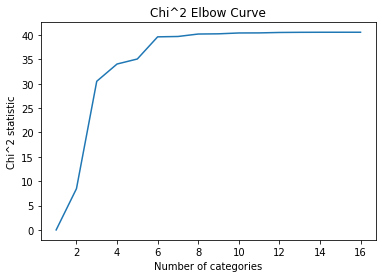

<Figure size 3600x720 with 0 Axes>

order_item_id
1    Mecklenburg-Western Pomerania+Saxony+Schleswig...
2    Mecklenburg-Western Pomerania+Saxony+Schleswig...
3    Mecklenburg-Western Pomerania+Saxony+Schleswig...
4    Mecklenburg-Western Pomerania+Saxony+Schleswig...
5    Mecklenburg-Western Pomerania+Saxony+Schleswig...
Name: user_state, dtype: category
Categories (1, object): ['Mecklenburg-Western Pomerania+Saxony+Schleswi...]
- 16 categories: ['Baden-Wuerttemberg' 'Bavaria' 'Berlin' 'Brandenburg' 'Bremen' 'Hamburg'
 'Hesse' 'Lower Saxony' 'Mecklenburg-Western Pomerania'
 'North Rhine-Westphalia' 'Rhineland-Palatinate' 'Saarland' 'Saxony'
 'Saxony-Anhalt' 'Schleswig-Holstein' 'Thuringia']
- 15 categories: ['Baden-Wuerttemberg' 'Bavaria' 'Bremen' 'Hamburg' 'Hesse' 'Lower Saxony'
 'Mecklenburg-Western Pomerania' 'North Rhine-Westphalia'
 'Rhineland-Palatinate' 'Saarland' 'Saxony' 'Saxony-Anhalt'
 'Schleswig-Holstein' 'Thuringia' 'Berlin+Brandenburg']
- 14 categories: ['Baden-Wuerttemberg' 'Bavaria' 'Bremen' 'Hamburg' '

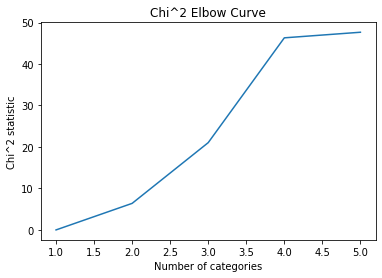

<Figure size 3600x720 with 0 Axes>

order_item_id
1    Company+Mrs+Mr+Family+not reported
2    Company+Mrs+Mr+Family+not reported
3    Company+Mrs+Mr+Family+not reported
4    Company+Mrs+Mr+Family+not reported
5    Company+Mrs+Mr+Family+not reported
Name: user_title, dtype: category
Categories (1, object): ['Company+Mrs+Mr+Family+not reported']
- 5 categories: ['Company' 'Family' 'Mr' 'Mrs' 'not reported']
- 4 categories: ['Company' 'Mrs' 'not reported' 'Mr+Family']
- 3 categories: ['Company' 'not reported' 'Mrs+Mr+Family']
- 2 categories: ['not reported' 'Company+Mrs+Mr+Family']
- 1 categories: ['Company+Mrs+Mr+Family+not reported']


([47.66050534116354,
  46.31228014465309,
  21.04332302637045,
  6.400489145748128,
  0.0],
 [Index(['Company', 'Family', 'Mr', 'Mrs', 'not reported'], dtype='object'),
  Index(['Company', 'Mrs', 'not reported', 'Mr+Family'], dtype='object'),
  Index(['Company', 'not reported', 'Mrs+Mr+Family'], dtype='object'),
  Index(['not reported', 'Company+Mrs+Mr+Family'], dtype='object'),
  Index(['Company+Mrs+Mr+Family+not reported'], dtype='object')])

In [396]:
ob_vars = df_known.select_dtypes(include='object').columns 
df_known[ob_vars] = df_known[ob_vars].astype('category')

optimize_grouping(cat_feature    = df_known['user_state'],target_feature = df_known['return'])
optimize_grouping(cat_feature    = df_known['user_title'],target_feature = df_known['return'])

These elbow curves show how large the chi-square value is for each number of combinations of categories. Ideally, an elbow point is chosen, where the chi-squared value is still quite high while the number of categories is relatively low. Looking at both graphs, the minimum number of characteristics to be retained is 6 for user_states and 4 for user_titles. All combinations are listed below the graph. Next, it is checked whether less data driven mergings appear more reasonable.

In [397]:
df_known.groupby('user_state')['return'].mean().sort_values()

user_state
Bremen                           0.418006
Hamburg                          0.438511
Thuringia                        0.442922
North Rhine-Westphalia           0.448885
Baden-Wuerttemberg               0.456953
Rhineland-Palatinate             0.458245
Hesse                            0.459247
Saarland                         0.461105
Saxony-Anhalt                    0.462511
Brandenburg                      0.463205
Berlin                           0.463439
Lower Saxony                     0.466072
Bavaria                          0.467931
Schleswig-Holstein               0.469362
Saxony                           0.476358
Mecklenburg-Western Pomerania    0.479511
Name: return, dtype: float64

These mean values show how much percent of orders is returned for each state. One might be tempted to group by city-states, Western Germany and Eastern Germany, however given the chi-squared curve, this approach will be refrained.

In [398]:
df_known.groupby('user_title')['return'].mean().sort_values()

user_title
not reported    0.336283
Family          0.393939
Mr              0.424470
Mrs             0.460860
Company         0.625000
Name: return, dtype: float64

The difference between Mr and Family is the lowest, it can be assumed that this is why the chi-squared approach gives this as the first merge. However, the merge with the next smallest difference would be Mr+Mrs. As this makes sense since both categories represent individuals, the purely data driven approach will be refrained here Mr and Mrs are to be merged into one category.

In [399]:
remap_dict_state = {
    'Bremen': 'Bremen',
    'Hamburg': 'Thuringia+Hamburg',
    'North Rhine-Westphalia': 'North Rhine-Westphalia',
    'Thuringia': 'Thuringia+Hamburg',
    'Mecklenburg-Western Pomerania': 'Mecklenburg-Western Pomerania+Saxony',
    'Saxony': 'Mecklenburg-Western Pomerania+Saxony',
    'Schleswig-Holstein': 'Schleswig-Holstein+Bavaria+Lower Saxony+Berlin+Brandenburg+Saxony-Anhalt+Saarland',
    'Bavaria': 'Schleswig-Holstein+Bavaria+Lower Saxony+Berlin+Brandenburg+Saxony-Anhalt+Saarland',
    'Lower Saxony': 'Schleswig-Holstein+Bavaria+Lower Saxony+Berlin+Brandenburg+Saxony-Anhalt+Saarland',
    'Berlin': 'Schleswig-Holstein+Bavaria+Lower Saxony+Berlin+Brandenburg+Saxony-Anhalt+Saarland',
    'Brandenburg': 'Schleswig-Holstein+Bavaria+Lower Saxony+Berlin+Brandenburg+Saxony-Anhalt+Saarland',
    'Saxony-Anhalt': 'Schleswig-Holstein+Bavaria+Lower Saxony+Berlin+Brandenburg+Saxony-Anhalt+Saarland',
    'Saarland': 'Schleswig-Holstein+Bavaria+Lower Saxony+Berlin+Brandenburg+Saxony-Anhalt+Saarland',
    'Hesse': 'Hesse+Rhineland-Palatinate+Baden-Wuerttemberg',
    'Rhineland-Palatinate': 'Hesse+Rhineland-Palatinate+Baden-Wuerttemberg',
    'Baden-Wuerttemberg': 'Hesse+Rhineland-Palatinate+Baden-Wuerttemberg'}

df_known['user_state_merged'] = df_known['user_state'].map(remap_dict_state).astype('category') #use the dictionary to merge categories as given in the keys

remap_dict_title = {
    'not reported': 'not reported',
    'Family': 'Family',
    'Mr': 'Individuals',
    'Mrs': 'Individuals',
    'Company': 'Company'}

df_known['user_title_merged'] = df_known['user_title'].map(remap_dict_title).astype('category') #use the dictionary to merge categories as given in the keys

For completion, the original features are not deleted yet to assess their importance as well at a later point.

## Determine and handle outliers 

From previous operations it was already shown that the dataset contains outliers. An outlier is either a value much larger or smaller than the rest of its affiliated values or it can be assumed that it must have arisen from errors, as for example a negative delivery time. Before jumping into deeper analysis, The datatype of all numerical features is adjusted to a uniform float32. As return is a binary feature, it is adjusted to the datatype bool. Note the decrease of memory usage compared to the unandjusted dataset.

In [400]:
df_known['return'] = df_known['return'].astype(bool)

int_vars = df_known.select_dtypes(include='int64').columns   
df_known[int_vars] = df_known[int_vars].astype('float32')
fl_vars = df_known.select_dtypes(include='float64').columns   
df_known[fl_vars] = df_known[fl_vars].astype('float32')

df_known['item_price'] = df_known['item_price'].astype('float32')

df_known.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 98998 entries, 1 to 100000
Data columns (total 18 columns):
 #   Column                  Non-Null Count  Dtype   
---  ------                  --------------  -----   
 0   item_price              98998 non-null  float32 
 1   user_title              98998 non-null  category
 2   user_state              98998 non-null  category
 3   return                  98998 non-null  bool    
 4   delivery_time           89875 non-null  float32 
 5   user_age                90364 non-null  float32 
 6   registration_age        98998 non-null  float32 
 7   order_age               98998 non-null  float32 
 8   order_month             98998 non-null  int64   
 9   order_day               98998 non-null  int64   
 10  item_id_freq            98998 non-null  float32 
 11  brand_id_freq           98998 non-null  float32 
 12  user_id_freq            98998 non-null  float32 
 13  item_size_freq          98998 non-null  float32 
 14  item_color_freq      

### Upper outliers

Next, categorical variables will be excluded to make sorting of the dataframe possible. This gives another idea of whether large values occur often (no outlier) or less often (potential outlier).

In [401]:
x = df_known.select_dtypes(exclude='category') #exclude categorical features as they cannot be sorted

#custom function to sort all features in the dataframe at once.
#Note that components of each order are shuffled, reading row-wise is hence misleading.
def sorted_a(s, num):                           
    tmp = s.sort_values(ascending=False)[:num]   
    tmp.index = range(num)
    return tmp

x.apply(lambda x: sorted_a(x, 50))


,item_price,return,delivery_time,user_age,registration_age,order_age,order_month,order_day,item_id_freq,brand_id_freq,user_id_freq,item_size_freq,item_color_freq,customers_order_number
0,999.000000,True,173.0,115.807991,1.566083,4.528498,9,31,0.010313,0.111992,0.001727,0.123184,0.186377,171
1,999.000000,True,153.0,115.805252,1.566083,4.528498,9,31,0.010313,0.111992,0.001727,0.123184,0.186377,170
2,999.000000,True,140.0,115.805252,1.566083,4.528498,9,31,0.010313,0.111992,0.001727,0.123184,0.186377,169
3,999.000000,True,139.0,115.805252,1.566083,4.528498,9,31,0.010313,0.111992,0.001727,0.123184,0.186377,168
4,399.950012,True,135.0,115.805252,1.566083,4.528498,9,31,0.010313,0.111992,0.001727,0.123184,0.186377,167
5,399.950012,True,135.0,115.805252,1.566083,4.528498,9,31,0.010313,0.111992,0.001727,0.123184,0.186377,166
6,399.950012,True,126.0,115.805252,1.566083,4.528498,9,31,0.010313,0.111992,0.001727,0.123184,0.186377,165
7,399.950012,True,126.0,115.805252,1.566083,4.528498,9,31,0.010313,0.111992,0.001727,0.123184,0.186377,164
8,399.950012,True,125.0,115.805252,1.566083,4.528498,9,31,0.010313,0.111992,0.001727,0.123184,0.186377,163
9,399.950012,True,122.0,115.805252,1.566083,4.528498,9,31,0.010313,0.111992,0.001727,0.123184,0.186377,162


Item_price and user_age stick out. These will be analyzed further for upper outliers.

In [402]:
df_known.nlargest( 10 , columns = 'item_price') #sort the dataframe by item_price, row-wise reading can be done


,item_price,user_title,user_state,return,delivery_time,user_age,registration_age,order_age,order_month,order_day,item_id_freq,brand_id_freq,user_id_freq,item_size_freq,item_color_freq,customers_order_number,user_state_merged,user_title_merged
order_item_id,,,,,,,,,,,,,,,,,,
48480,999.000000,Mr,North Rhine-Westphalia,False,NaN,44.710022,-0.002738,4.416244,8,2,0.000040,0.000040,0.000010,0.051425,0.186377,1,North Rhine-Westphalia,Individuals
49211,999.000000,Mr,Baden-Wuerttemberg,True,-7886.0,67.382629,-0.002738,4.413506,8,3,0.000040,0.000040,0.000010,0.051425,0.186377,1,Hesse+Rhineland-Palatinate+Baden-Wuerttemberg,Individuals
65020,999.000000,Mrs,Baden-Wuerttemberg,True,-7894.0,44.633362,0.342238,4.391603,8,11,0.000040,0.000040,0.000020,0.051425,0.186377,1,Hesse+Rhineland-Palatinate+Baden-Wuerttemberg,Individuals
70149,999.000000,Mrs,Baden-Wuerttemberg,False,0.0,44.644310,0.353190,4.380651,8,15,0.000040,0.000040,0.000020,0.051425,0.186377,2,Hesse+Rhineland-Palatinate+Baden-Wuerttemberg,Individuals
41330,399.950012,Mr,Hesse,True,14.0,45.449257,1.429187,4.443623,7,23,0.000313,0.004586,0.000051,0.039577,0.000455,3,Hesse+Rhineland-Palatinate+Baden-Wuerttemberg,Individuals
55805,399.950012,Mrs,Baden-Wuerttemberg,True,2.0,46.456806,1.467518,4.405293,8,6,0.000313,0.004586,0.000232,0.089456,0.072698,15,Hesse+Rhineland-Palatinate+Baden-Wuerttemberg,Individuals
61960,399.950012,Mr,Bavaria,False,4.0,NaN,-0.002738,4.397079,8,9,0.000313,0.004586,0.000010,0.039577,0.186377,1,Schleswig-Holstein+Bavaria+Lower Saxony+Berlin...,Individuals
64679,399.950012,Mrs,Baden-Wuerttemberg,True,3.0,43.806511,1.481208,4.391603,8,11,0.000313,0.004586,0.000071,0.089456,0.186377,7,Hesse+Rhineland-Palatinate+Baden-Wuerttemberg,Individuals
66906,399.950012,Mrs,Lower Saxony,True,2.0,40.433411,-0.002738,4.386127,8,13,0.000313,0.004586,0.000040,0.089456,0.186377,1,Schleswig-Holstein+Bavaria+Lower Saxony+Berlin...,Individuals


There seems to be no inconsistency with the orders containing items with a very high price. Given the possibility that this online-shop may also sell luxury articles, it can also not be excluded that this expensive articles are sold. Hence, very expensive articles and their price are treated as "real" and will not be altered.

(array([3.9000e+01, 2.9900e+02, 5.2730e+03, 2.9681e+04, 4.0790e+04,
        1.1988e+04, 1.0150e+03, 6.0000e+01, 8.0000e+00, 1.2110e+03]),
 array([  4.94466 ,  16.030993,  27.117327,  38.20366 ,  49.289993,
         60.376328,  71.46266 ,  82.54899 ,  93.63532 , 104.72166 ,
        115.80799 ], dtype=float32),
 <a list of 10 Patch objects>)

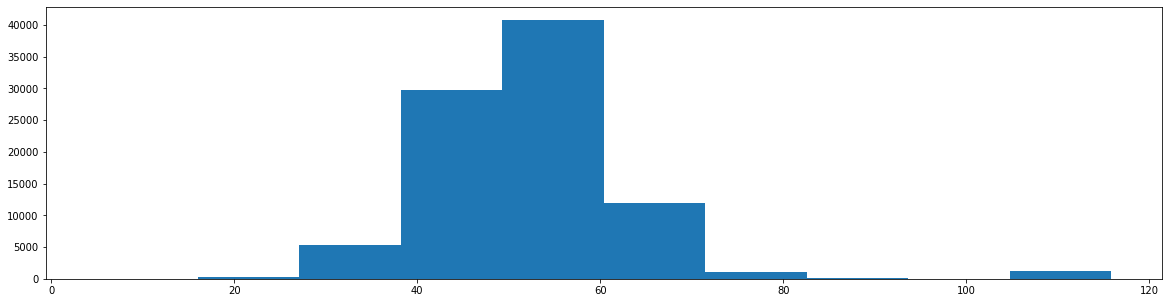

In [403]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20, 5))
plt.hist(df_known['user_age']) 

As can be seen from the plot above, user_age is somewhat normally distributed, if there were no user's with an age of around 110-120. Although it cannot be excluded to have users who are that old, it should be excludable to have that many in comparison to other senior customers. Looking at the plot, it will be assumed that the maximum age of a user is to be set at 90.  To put it into numbers, the relative amount of users older than 90 is given below. Following this, all users with a higher age will be treated as outliers and their age will be adjusted to 90, while leaving out missing values as their treatment requires to be done at a later stage of Data Preparation.

In [404]:
len(df_known[df_known['user_age'] > 90])/len(df_known)

0.01250530313743712

In [405]:
df_known['user_age'].where((df_known['user_age'] < 90) | (df_known['user_age'].isna()), 90, inplace = True) #replace all values smaller or equal 90 to 90, excluding empty cells
df_known.isnull().sum()

item_price                   0
user_title                   0
user_state                   0
return                       0
delivery_time             9123
user_age                  8634
registration_age             0
order_age                    0
order_month                  0
order_day                    0
item_id_freq                 0
brand_id_freq                0
user_id_freq                 0
item_size_freq               0
item_color_freq              0
customers_order_number       0
user_state_merged            0
user_title_merged            0
dtype: int64

In [406]:
df_known.describe()

,item_price,delivery_time,user_age,registration_age,order_age,order_month,order_day,item_id_freq,brand_id_freq,user_id_freq,item_size_freq,item_color_freq,customers_order_number
count,98998.000000,89875.000000,90364.000000,98998.000000,98998.000000,98998.000000,98998.000000,98998.000000,98998.000000,98998.000000,98998.000000,98998.000000,98998.000000
mean,65.421646,-83.568970,51.983543,0.748345,4.425240,7.435898,15.904321,0.001881,0.035009,0.000121,0.069778,0.077795,6.473373
std,48.019058,842.413269,9.652616,0.610564,0.067928,0.939747,10.082192,0.001968,0.035252,0.000142,0.038137,0.061139,8.817745
min,0.000000,-7925.000000,4.944660,-0.002738,4.306728,6.000000,1.000000,0.000010,0.000010,0.000010,0.000010,0.000020,1.000000
25%,31.950001,2.000000,46.161114,0.060234,4.366961,7.000000,6.000000,0.000596,0.009576,0.000040,0.047617,0.023243,2.000000
50%,49.900002,3.000000,51.532887,0.711856,4.413506,8.000000,15.000000,0.001283,0.018425,0.000081,0.077345,0.072698,4.000000
75%,79.900002,5.000000,57.238686,1.377167,4.501119,8.000000,27.000000,0.002293,0.046799,0.000141,0.101790,0.106386,8.000000
max,999.000000,173.000000,90.000000,1.566083,4.528498,9.000000,31.000000,0.010313,0.111992,0.001727,0.123184,0.186377,171.000000


(array([3.9000e+01, 2.3000e+01, 7.3300e+02, 5.8530e+03, 2.1072e+04,
        3.5966e+04, 1.9726e+04, 4.9760e+03, 6.4000e+02, 1.3360e+03]),
 array([ 4.94466 , 13.450194, 21.955729, 30.461262, 38.966797, 47.47233 ,
        55.977863, 64.4834  , 72.98893 , 81.49447 , 90.      ],
       dtype=float32),
 <a list of 10 Patch objects>)

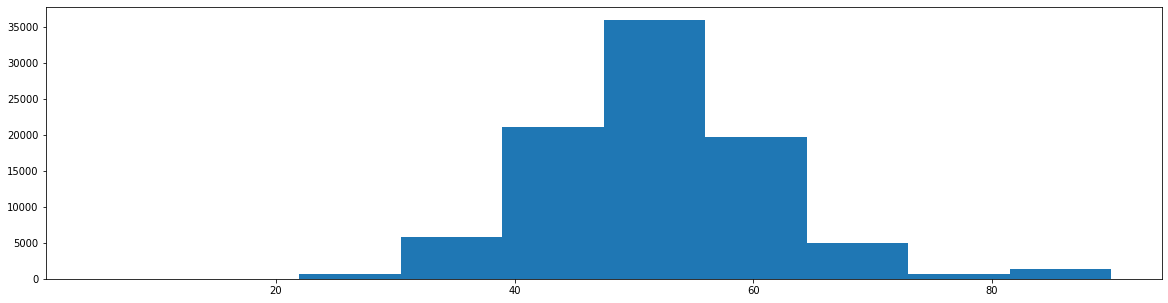

In [407]:
plt.figure(figsize=(20, 5))
plt.hist(df_known['user_age']) 

Although far from perfect, this plot still comes closer to a normal distribution than before and does not contain upper values that may confidently be considered as erroneous.

### Lower outliers

First, the dataframe is again sorted to detect columns with potential lower outliers.

In [408]:

def sorted_d(s, num):
    tmp = s.sort_values(ascending=True)[:num] 
    tmp.index = range(num)
    return tmp
x.apply(lambda x: sorted_d(x, 50))

,item_price,return,delivery_time,user_age,registration_age,order_age,order_month,order_day,item_id_freq,brand_id_freq,user_id_freq,item_size_freq,item_color_freq,customers_order_number
0,0.0,False,-7925.0,4.944660,-0.002738,4.306728,6,1,0.00001,0.000010,0.00001,0.000010,0.000020,1
1,0.0,False,-7925.0,4.944660,-0.002738,4.306728,6,1,0.00001,0.000010,0.00001,0.000010,0.000020,1
2,0.0,False,-7925.0,4.944660,-0.002738,4.306728,6,1,0.00001,0.000010,0.00001,0.000010,0.000040,1
3,0.0,False,-7925.0,5.062390,-0.002738,4.306728,6,1,0.00001,0.000010,0.00001,0.000010,0.000040,1
4,0.0,False,-7925.0,5.062390,-0.002738,4.306728,6,1,0.00001,0.000010,0.00001,0.000010,0.000040,1
5,0.0,False,-7924.0,5.062390,-0.002738,4.306728,6,1,0.00001,0.000010,0.00001,0.000010,0.000040,1
6,0.0,False,-7924.0,5.254044,-0.002738,4.306728,6,1,0.00001,0.000010,0.00001,0.000010,0.000040,1
7,0.0,False,-7924.0,5.254044,-0.002738,4.306728,6,1,0.00001,0.000010,0.00001,0.000010,0.000040,1
8,0.0,False,-7924.0,5.426532,-0.002738,4.306728,6,1,0.00001,0.000020,0.00001,0.000020,0.000040,1
9,0.0,False,-7924.0,5.429270,-0.002738,4.306728,6,1,0.00001,0.000020,0.00001,0.000020,0.000040,1


Item_price, delivery_time, user_age and registration_age stick out. Although prices should not be prone to measurement errors and free articles do appear in online-shops for example as a promotion, item_price will still be analyzed. In contrast, negative delivery_time values must be a result of error and therefore need to be treated definetively. While it is not impossible for a customer to be still a child, 4-year-olds should still be taken a more detailed look to make sure they are no outliers. Negative registration_age values are possible, as sometimes online-shops offer ordering without registration. A negative registration time should therefore not be unlikely, however it will still be looked into detail.

In [409]:
len(df_known[df_known['item_price'] == 0]) #number of items with price 0

341

In [410]:
df_known.nsmallest( 396 , columns = 'item_price') #show all orders where the item costs 0

,item_price,user_title,user_state,return,delivery_time,user_age,registration_age,order_age,order_month,order_day,item_id_freq,brand_id_freq,user_id_freq,item_size_freq,item_color_freq,customers_order_number,user_state_merged,user_title_merged
order_item_id,,,,,,,,,,,,,,,,,,
203,0.0,Mrs,Lower Saxony,False,3.0,58.046368,1.322409,4.525760,6,23,0.001899,0.005041,0.000061,0.051425,0.038910,4,Schleswig-Holstein+Bavaria+Lower Saxony+Berlin...,Individuals
217,0.0,Mrs,Saxony,True,3.0,47.234371,1.007550,4.525760,6,23,0.001899,0.005041,0.000051,0.051425,0.038910,5,Mecklenburg-Western Pomerania+Saxony,Individuals
219,0.0,Mrs,North Rhine-Westphalia,False,4.0,60.633690,1.347050,4.525760,6,23,0.001899,0.005041,0.000030,0.051425,0.038910,2,North Rhine-Westphalia,Individuals
352,0.0,Mrs,North Rhine-Westphalia,False,4.0,54.435066,0.643408,4.525760,6,23,0.001899,0.005041,0.000162,0.051425,0.038910,15,North Rhine-Westphalia,Individuals
444,0.0,Mrs,North Rhine-Westphalia,False,3.0,71.191055,0.626981,4.525760,6,23,0.001899,0.005041,0.000020,0.051425,0.038910,2,North Rhine-Westphalia,Individuals
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11748,4.9,Mrs,Lower Saxony,False,NaN,46.292530,1.349788,4.512071,6,28,0.000747,0.000747,0.000030,0.051425,0.006142,3,Schleswig-Holstein+Bavaria+Lower Saxony+Berlin...,Individuals
11942,4.9,Mrs,Bavaria,True,-7850.0,67.300491,0.082137,4.512071,6,28,0.000747,0.000747,0.000131,0.051425,0.038910,6,Schleswig-Holstein+Bavaria+Lower Saxony+Berlin...,Individuals
12473,4.9,Mrs,North Rhine-Westphalia,False,34.0,52.981239,0.807683,4.512071,6,28,0.000141,0.012798,0.000051,0.051425,0.011768,4,North Rhine-Westphalia,Individuals


In [411]:
df_known[df_known['item_price'] != 0].sort_values('item_price') #show the orders with the smallest item prices excluding those items with price 0

,item_price,user_title,user_state,return,delivery_time,user_age,registration_age,order_age,order_month,order_day,item_id_freq,brand_id_freq,user_id_freq,item_size_freq,item_color_freq,customers_order_number,user_state_merged,user_title_merged
order_item_id,,,,,,,,,,,,,,,,,,
24099,3.400000,Mrs,Bavaria,False,32.0,51.059227,1.368953,4.503857,7,1,0.000020,0.004586,0.001727,0.051425,0.003485,114,Schleswig-Holstein+Bavaria+Lower Saxony+Berlin...,Individuals
15203,3.400000,Mrs,Bavaria,False,NaN,51.053753,1.363478,4.509333,6,29,0.000020,0.004586,0.001727,0.051425,0.003485,51,Schleswig-Holstein+Bavaria+Lower Saxony+Berlin...,Individuals
34403,3.950000,Mrs,Brandenburg,True,10.0,90.000000,1.292292,4.471002,7,13,0.000030,0.006283,0.000061,0.051425,0.007899,5,Schleswig-Holstein+Bavaria+Lower Saxony+Berlin...,Individuals
34397,3.950000,Mrs,Brandenburg,False,NaN,90.000000,1.295030,4.468264,7,14,0.000030,0.006283,0.000061,0.051425,0.007899,1,Schleswig-Holstein+Bavaria+Lower Saxony+Berlin...,Individuals
34405,3.950000,Mrs,Brandenburg,False,10.0,90.000000,1.292292,4.471002,7,13,0.000030,0.006283,0.000061,0.051425,0.007899,6,Schleswig-Holstein+Bavaria+Lower Saxony+Berlin...,Individuals
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67831,399.950012,Mrs,North Rhine-Westphalia,True,2.0,NaN,-0.002738,4.386127,8,13,0.000313,0.004586,0.000020,0.089456,0.000455,2,North Rhine-Westphalia,Individuals
70149,999.000000,Mrs,Baden-Wuerttemberg,False,0.0,44.644310,0.353190,4.380651,8,15,0.000040,0.000040,0.000020,0.051425,0.186377,2,Hesse+Rhineland-Palatinate+Baden-Wuerttemberg,Individuals
48480,999.000000,Mr,North Rhine-Westphalia,False,NaN,44.710022,-0.002738,4.416244,8,2,0.000040,0.000040,0.000010,0.051425,0.186377,1,North Rhine-Westphalia,Individuals


As can be seen, the free items show some variation and there are also other items that are comparatively cheap, free items do therefore not have to be out of place. The feature will not be treated further here.

Below, the delivery_time values are plotted. As has already been pointed out, some delivery times contain negative values. Since a negative delivery time is logically impossible, the occurence of negative values must be due to errors. The plot visualizes the discrepancy of this column.

(array([ 1037.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0., 88838.]),
 array([-7925. , -7115.2, -6305.4, -5495.6, -4685.8, -3876. , -3066.2,
        -2256.4, -1446.6,  -636.8,   173. ], dtype=float32),
 <a list of 10 Patch objects>)

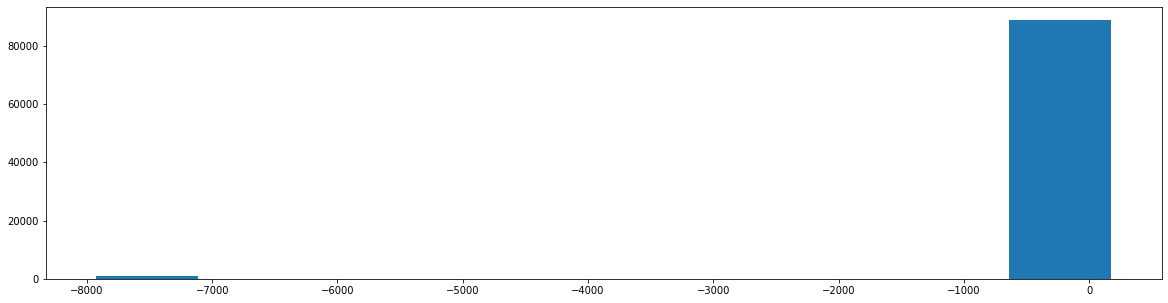

In [412]:
plt.figure(figsize=(20, 5))
plt.hist(df_known['delivery_time']) 

While a very old or too old user may still be old in reality, one cannot make any assumption about what real delivery_time value should be used for the negative ones. Because of this, the negative values will be replaced by the average of all positive values.

In [413]:
m = df_known [df_known['delivery_time']>0] #exclude negative delivery times
m = m['delivery_time'].mean(skipna=True)   #exclude empty cells
df_known['delivery_time'].where((df_known['delivery_time'] > 0) | (df_known['delivery_time'].isna()), m, inplace = True) #replace negative delivery times with the mean                                                                                                                      #of all positive delivery times, excluding empty cells

,item_price,delivery_time,user_age,registration_age,order_age,order_month,order_day,item_id_freq,brand_id_freq,user_id_freq,item_size_freq,item_color_freq,customers_order_number
count,98998.000000,89875.000000,90364.000000,98998.000000,98998.000000,98998.000000,98998.000000,98998.000000,98998.000000,98998.000000,98998.000000,98998.000000,98998.000000
mean,65.421646,7.440369,51.983543,0.748345,4.425240,7.435898,15.904321,0.001881,0.035009,0.000121,0.069778,0.077795,6.473373
std,48.019058,13.438853,9.652616,0.610564,0.067928,0.939747,10.082192,0.001968,0.035252,0.000142,0.038137,0.061139,8.817745
min,0.000000,1.000000,4.944660,-0.002738,4.306728,6.000000,1.000000,0.000010,0.000010,0.000010,0.000010,0.000020,1.000000
25%,31.950001,2.000000,46.161114,0.060234,4.366961,7.000000,6.000000,0.000596,0.009576,0.000040,0.047617,0.023243,2.000000
50%,49.900002,3.000000,51.532887,0.711856,4.413506,8.000000,15.000000,0.001283,0.018425,0.000081,0.077345,0.072698,4.000000
75%,79.900002,5.000000,57.238686,1.377167,4.501119,8.000000,27.000000,0.002293,0.046799,0.000141,0.101790,0.106386,8.000000
max,999.000000,173.000000,90.000000,1.566083,4.528498,9.000000,31.000000,0.010313,0.111992,0.001727,0.123184,0.186377,171.000000


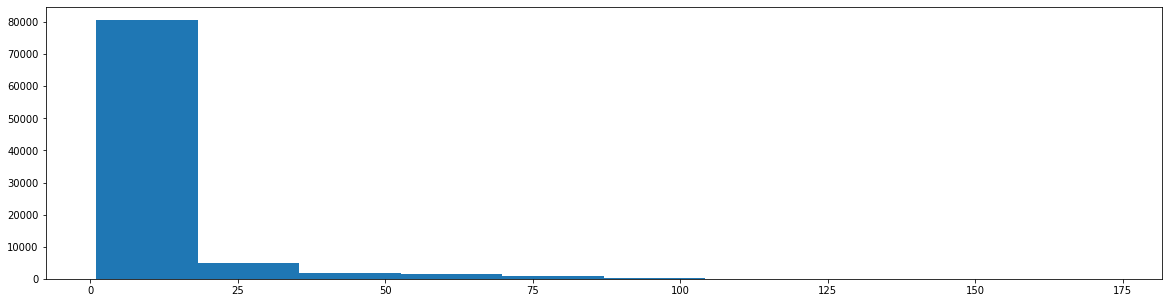

In [414]:
plt.figure(figsize=(20, 5))
plt.hist(df_known['delivery_time']) 
df_known.describe()

User's age is next analyzed. Plotting a histogram again, it can be seen that the amount of users under 20 is marginal. However, they should not be excluded or changed without reason, as this may result into bias. Hence the orders of these children is to be analyzed deeper.

,item_price,user_title,user_state,return,delivery_time,user_age,registration_age,order_age,order_month,order_day,item_id_freq,brand_id_freq,user_id_freq,item_size_freq,item_color_freq,customers_order_number,user_state_merged,user_title_merged
order_item_id,,,,,,,,,,,,,,,,,,
4717,29.950001,Mrs,Saarland,False,2.0,4.944660,0.832324,4.517547,6,26,0.000253,0.012930,0.000061,0.000323,0.087588,1,Schleswig-Holstein+Bavaria+Lower Saxony+Berlin...,Individuals
4718,29.950001,Mrs,Saarland,False,2.0,4.944660,0.832324,4.517547,6,26,0.000253,0.012930,0.000061,0.002465,0.086982,2,Schleswig-Holstein+Bavaria+Lower Saxony+Berlin...,Individuals
4719,27.450001,Mrs,Saarland,False,NaN,4.944660,0.832324,4.517547,6,26,0.000354,0.011909,0.000061,0.001768,0.086982,3,Schleswig-Holstein+Bavaria+Lower Saxony+Berlin...,Individuals
59044,39.900002,Mrs,Saarland,False,2.0,5.062390,0.950054,4.399817,8,8,0.000303,0.008889,0.000061,0.050001,0.019617,4,Schleswig-Holstein+Bavaria+Lower Saxony+Berlin...,Individuals
59045,29.900000,Mrs,Saarland,False,2.0,5.062390,0.950054,4.399817,8,8,0.001121,0.010212,0.000061,0.047617,0.186377,5,Schleswig-Holstein+Bavaria+Lower Saxony+Berlin...,Individuals
59046,59.900002,Mrs,Saarland,False,2.0,5.062390,0.950054,4.399817,8,8,0.000111,0.005778,0.000061,0.047617,0.087588,6,Schleswig-Holstein+Bavaria+Lower Saxony+Berlin...,Individuals
81095,39.900002,Mrs,Berlin,True,3.0,5.254044,1.141707,4.353272,8,25,0.002192,0.010212,0.000020,0.056334,0.106386,1,Schleswig-Holstein+Bavaria+Lower Saxony+Berlin...,Individuals
81096,49.950001,Mrs,Berlin,False,3.0,5.254044,1.141707,4.353272,8,25,0.003121,0.012930,0.000020,0.003293,0.023243,2,Schleswig-Holstein+Bavaria+Lower Saxony+Berlin...,Individuals
36781,79.900002,Mrs,Schleswig-Holstein,False,4.0,5.426532,1.314195,4.465526,7,15,0.001131,0.084426,0.000010,0.065547,0.186377,1,Schleswig-Holstein+Bavaria+Lower Saxony+Berlin...,Individuals


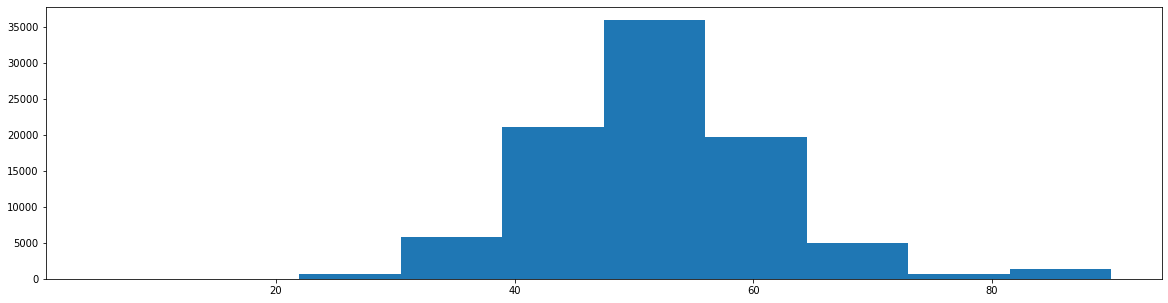

In [415]:
plt.figure(figsize=(20, 5))
plt.hist(df_known['user_age']) 
df_known.nsmallest( 50 , columns = 'user_age') #check orders of the 50 youngest customers

There are less than 50 children buying at this shop and the items their orders exceed the typical amount of pocket money. As there is a "drop" from 17 to 10 and since only adults are allowed to buy items all by their own in Germany (Verbraucherzentrale Bundesverband, 2019), all user_ages below 17 will be adjusted.

(array([  149.,   943.,  5445., 16235., 30655., 23629.,  9882.,  1694.,
          463.,  1269.]),
 array([17. , 24.3, 31.6, 38.9, 46.2, 53.5, 60.8, 68.1, 75.4, 82.7, 90. ],
       dtype=float32),
 <a list of 10 Patch objects>)

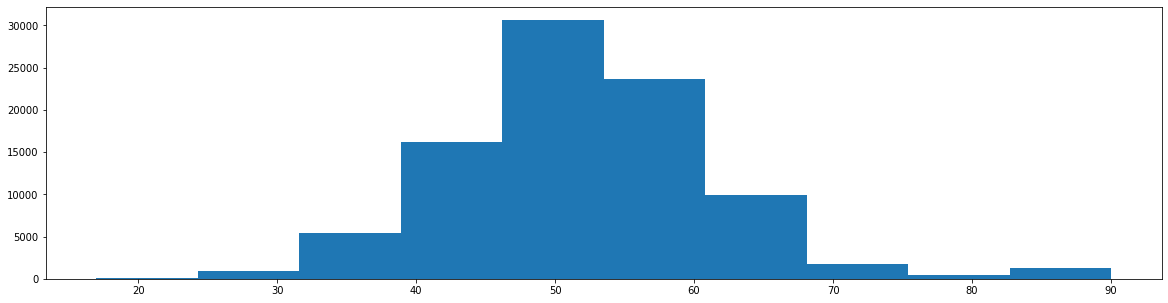

In [416]:
df_known['user_age'].where((df_known['user_age'] > 17) | (df_known['user_age'].isna()), 17, inplace = True) #replace user_ages below 17 with 17 while excluding empty cells
plt.figure(figsize=(20, 5))
plt.hist(df_known['user_age']) 

Last, registration_age is to be looked upon.

0.20276167195296874


(array([28631.,  6627.,  7076.,  5390.,  3591.,  4374.,  3025.,  2557.,
        16671., 21056.]),
 array([-0.00273791,  0.15414417,  0.31102625,  0.46790832,  0.6247904 ,
         0.7816725 ,  0.9385545 ,  1.0954366 ,  1.2523187 ,  1.4092008 ,
         1.5660828 ], dtype=float32),
 <a list of 10 Patch objects>)

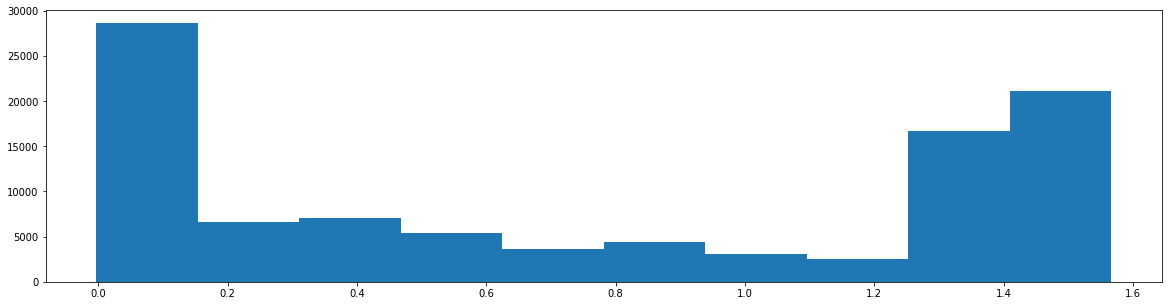

In [417]:
print (len(df_known[df_known['registration_age'] < 0])/(len(df_known))) #share of negative registration_ages
plt.figure(figsize=(20, 5))
plt.hist(df_known['registration_age']) 

In [418]:
df_known.nsmallest( 50 , columns = 'registration_age')

,item_price,user_title,user_state,return,delivery_time,user_age,registration_age,order_age,order_month,order_day,item_id_freq,brand_id_freq,user_id_freq,item_size_freq,item_color_freq,customers_order_number,user_state_merged,user_title_merged
order_item_id,,,,,,,,,,,,,,,,,,
1,49.900002,Mrs,Saxony,False,5.0,47.182350,-0.002738,4.528498,6,22,0.000222,0.012798,0.000030,0.056334,0.003152,1,Mecklenburg-Western Pomerania+Saxony,Individuals
2,19.950001,Mrs,Saxony,False,NaN,47.182350,-0.002738,4.528498,6,22,0.000505,0.012798,0.000030,0.000970,0.086982,2,Mecklenburg-Western Pomerania+Saxony,Individuals
12,39.900002,Mrs,Lower Saxony,False,5.0,NaN,-0.002738,4.528498,6,22,0.002253,0.050405,0.000030,0.123184,0.086982,1,Schleswig-Holstein+Bavaria+Lower Saxony+Berlin...,Individuals
13,59.900002,Mrs,Lower Saxony,False,5.0,NaN,-0.002738,4.528498,6,22,0.001444,0.050405,0.000030,0.123184,0.186377,2,Schleswig-Holstein+Bavaria+Lower Saxony+Berlin...,Individuals
14,29.900000,Mrs,Lower Saxony,False,5.0,NaN,-0.002738,4.528498,6,22,0.002950,0.111992,0.000030,0.123184,0.186377,3,Schleswig-Holstein+Bavaria+Lower Saxony+Berlin...,Individuals
70,29.900000,Mrs,Bavaria,True,3.0,46.637508,-0.002738,4.525760,6,23,0.008131,0.017546,0.000071,0.123184,0.106386,1,Schleswig-Holstein+Bavaria+Lower Saxony+Berlin...,Individuals
71,39.900002,Mrs,Bavaria,False,3.0,46.637508,-0.002738,4.525760,6,23,0.008131,0.017546,0.000071,0.123184,0.106386,2,Schleswig-Holstein+Bavaria+Lower Saxony+Berlin...,Individuals
72,39.900002,Mrs,Bavaria,True,3.0,46.637508,-0.002738,4.525760,6,23,0.008131,0.017546,0.000071,0.123184,0.086982,3,Schleswig-Holstein+Bavaria+Lower Saxony+Berlin...,Individuals
73,99.900002,Mrs,Bavaria,False,3.0,46.637508,-0.002738,4.525760,6,23,0.000374,0.005041,0.000071,0.003869,0.106386,4,Schleswig-Holstein+Bavaria+Lower Saxony+Berlin...,Individuals


In [419]:
print(df_known['registration_age'].min() * 365) #convert the smallest registration_age from years to days

-0.9993360529188067


From the results above, one can observe that the amount of negative registration_ages is quite high with more than a fifth of all registration_ages. These negative values also tend to be marginal, as the crossing of the 0 to the left can barely be noticed. The column is named age, as the values resemble years. To convert the lowest value into days, it can be multiplied by 365. The result is ~ -1, which means that the lowest amount of time between an order and a late registration is one day. This does not stand out, and given the large prevalence, these values will not be classified as outliers and remain untreated.

## Fill cells with missing values with their respective mean


In [420]:
df_known.isnull().sum()

item_price                   0
user_title                   0
user_state                   0
return                       0
delivery_time             9123
user_age                  8634
registration_age             0
order_age                    0
order_month                  0
order_day                    0
item_id_freq                 0
brand_id_freq                0
user_id_freq                 0
item_size_freq               0
item_color_freq              0
customers_order_number       0
user_state_merged            0
user_title_merged            0
dtype: int64

Now that all outliers have been detected and adjusted, missing values can be replaced. As there is no reason to pick a specific value, the mean of every column will be chosen.

In [421]:
m = df_known['delivery_time'].mean(skipna=True)                  
df_known['delivery_time'].fillna(m, inplace=True)

m = df_known['user_age'].mean(skipna=True)                  
df_known['user_age'].fillna(m, inplace=True)

In [422]:
df_known.isnull().sum()

item_price                0
user_title                0
user_state                0
return                    0
delivery_time             0
user_age                  0
registration_age          0
order_age                 0
order_month               0
order_day                 0
item_id_freq              0
brand_id_freq             0
user_id_freq              0
item_size_freq            0
item_color_freq           0
customers_order_number    0
user_state_merged         0
user_title_merged         0
dtype: int64

In [423]:
df_known.describe()

,item_price,delivery_time,user_age,registration_age,order_age,order_month,order_day,item_id_freq,brand_id_freq,user_id_freq,item_size_freq,item_color_freq,customers_order_number
count,98998.000000,98998.000000,98998.000000,98998.000000,98998.000000,98998.000000,98998.000000,98998.000000,98998.000000,98998.000000,98998.000000,98998.000000,98998.000000
mean,65.421646,7.440166,51.988319,0.748345,4.425240,7.435898,15.904321,0.001881,0.035009,0.000121,0.069778,0.077795,6.473373
std,48.019058,12.804707,9.203169,0.610564,0.067928,0.939747,10.082192,0.001968,0.035252,0.000142,0.038137,0.061139,8.817745
min,0.000000,1.000000,17.000000,-0.002738,4.306728,6.000000,1.000000,0.000010,0.000010,0.000010,0.000010,0.000020,1.000000
25%,31.950001,2.000000,46.705956,0.060234,4.366961,7.000000,6.000000,0.000596,0.009576,0.000040,0.047617,0.023243,2.000000
50%,49.900002,3.000000,51.988255,0.711856,4.413506,8.000000,15.000000,0.001283,0.018425,0.000081,0.077345,0.072698,4.000000
75%,79.900002,7.440369,56.587063,1.377167,4.501119,8.000000,27.000000,0.002293,0.046799,0.000141,0.101790,0.106386,8.000000
max,999.000000,173.000000,90.000000,1.566083,4.528498,9.000000,31.000000,0.010313,0.111992,0.001727,0.123184,0.186377,171.000000


## Pre-Modeling Feature Selection

Feature Selection can be done both before and after modeling the data. While selecting features before modeling may save time, it poses the risk of dropping features that could have been actually useful for the final model. In this paper, the features will be eaxmined first carefully by having a first look at the Fisher Score and the Information Value. A custom class will make this easily accessible for any given dataframe.

In [424]:
fl_vars = df_known.select_dtypes(include='float32').columns   #all numerical variables need to be of type float64 or alternatively int64
df_known[fl_vars] = df_known[fl_vars].astype('float64')

class filter_binary_target:
    def __init__(self, df, target):
        self.target = target
        self.data_head = df.head()

    def auto_filter_binary_target(self):                     #create the output dataframe
        data_no_target = df_known.drop(columns=self.target)  
        columns = ['Data Type', 'Metric', 'Score']
        index = data_no_target.columns
        result = pd.DataFrame(index=index, columns=columns)

        for col in data_no_target:                           #sort between discrete and continuous variables and assign later defined function
            if data_no_target.dtypes[col] == 'bool' or data_no_target.dtypes[col].name == 'category':
                result.loc[col, 'Data Type'] = "discrete"
                result.loc[col, 'Metric'] = "IV"
                result.loc[col, 'Score'] = self.IV_binary_target(feature=col)

            if data_no_target.dtypes[col] == 'int64' or data_no_target.dtypes[col] == 'float64':
                result.loc[col, 'Data Type'] = "continuous"
                result.loc[col, 'Metric'] = "Fisher"
                result.loc[col, 'Score'] = self.fisher_binary_target(feature=col)

        return result

    def IV_binary_target(self, feature):  # calculate the Weight of Evidence for each characteristic, 
        data = pd.DataFrame()             # multiply each with the difference of both target data distributions and sum it up to get the Information Value of the whole column 
    
        data['Count'] = df_known[feature].value_counts()
        data['Return'] = df_known.groupby([feature])[self.target].sum()
        data['Keep'] = data['Count'] - data['Return']
    
        data["Distribution Return"] = data["Return"] / data["Return"].sum()
        data["Distribution Keep"] = data["Keep"] / data["Keep"].sum()
    
        data['WOE'] = np.log(data["Distribution Keep"] / data["Distribution Return"])
        data.replace({"WOE": {np.inf: 0, -np.inf: 0}})

        data["IV"] = data["WOE"] * (data["Distribution Keep"] - data["Distribution Return"])

        iv = data["IV"].sum()

        return iv

    def fisher_binary_target(self, feature):                              # group numerical variables by the target variable and calculate both mean and variance for each, 
        mu_0 = df_known.groupby(df_known[self.target])[feature].mean()[0] # then take the absolute difference of the means and divide it by the 
        mu_1 = df_known.groupby(df_known[self.target])[feature].mean()[1] # square root of the product of the variances
        var_0 = df_known.groupby(df_known[self.target])[feature].var()[0]
        var_1 = df_known.groupby(df_known[self.target])[feature].var()[1]

        num = abs(mu_0 - mu_1)
        den = (var_0 + var_1) ** 0.5
        score = num/den
    
        return score

In [425]:
filter = filter_binary_target(df = df_known, target="return") #put in the dataframe and save results

table = filter.auto_filter_binary_target() #save table seperately
table.sort_values(by = ['Score'], ascending = False) #display table and sort it by the most important variables

,Data Type,Metric,Score
item_price,continuous,Fisher,0.197551
order_age,continuous,Fisher,0.0916887
order_month,continuous,Fisher,0.0837924
brand_id_freq,continuous,Fisher,0.0603349
user_age,continuous,Fisher,0.052064
user_id_freq,continuous,Fisher,0.0493864
registration_age,continuous,Fisher,0.0459243
item_id_freq,continuous,Fisher,0.0383042
item_color_freq,continuous,Fisher,0.0303357
customers_order_number,continuous,Fisher,0.0275785


As seen in the table above, all categorical features display an Information Value well below 0.02 . The rule of thumb states that any categorical variable with an Information Value beloww 0.02 is irrelevant. As a consequence, all categorical variables will be dropped.

The Fisher scores show that some numerical features are clearly more relevant than others. It is hard to tell though whether a feature should be dropped or not by the Fisher score alone. Further evaluation metrics for numerical features include the Extra Tree Classifier ((Shaikh, 2018) and Pearson’s chi-squared statistical hypothesis test for independence (Brownlee, 2020) are used below. 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  import sys


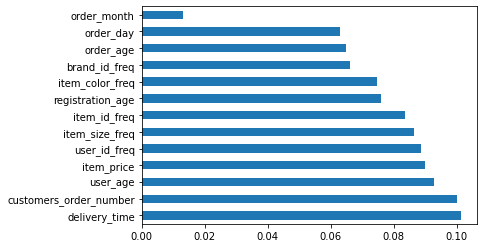

In [426]:
(X = df_known.select_dtypes(exclude='category').drop(['return'], axis=1) #select all numerical features
y = df_known[['return']]

from sklearn.ensemble import ExtraTreesClassifier

model = ExtraTreesClassifier()
model.fit(X,y) #fit the Extra Trees Classifier to obtain feature importances

#plot graph of feature importances 
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(20).plot(kind='barh') #plot all features, as the input needs to be a number, the number 20 was chosen to ensure all features are selected
plt.show()

In [427]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

X_positive = df_known.select_dtypes(exclude='category').drop(['return', 'registration_age'], axis=1) #select numerical positive variables

bestfeatures = SelectKBest(score_func=chi2, k='all') #apply SelectKBest class to extract top 10 best features
fit = bestfeatures.fit(X_positive,y)

dfscores = pd.DataFrame(fit.scores_) #save the scores as columns of a Dataframe
dfcolumns = pd.DataFrame(X_positive.columns) #save the feature names as columns of a Dataframe

featureScores = pd.concat([dfcolumns,dfscores],axis=1) #concat two dataframes for better visualization 
featureScores.columns = ['Features','Score']  #naming the dataframe columns

print(featureScores.nlargest(20,'Score'))  #print all features ordered by their score. 20 was again chosen to ensure all features are selected as a number is needed as an input

                  Features         Score
0               item_price  66973.871449
1            delivery_time    513.033394
11  customers_order_number    448.926302
2                 user_age    216.933811
5                order_day     57.802139
4              order_month     40.748652
7            brand_id_freq      6.295454
10         item_color_freq      2.173802
3                order_age      0.428238
9           item_size_freq      0.355129
6             item_id_freq      0.147151
8             user_id_freq      0.019950


As can be seen, results from the three feature scoring methods vary. It is hard to identify an overall tendency for a feature and thus also whether it is now important enough to keep or not. Therefore, the selection of numerical features will be entirely relocated to the Post-Modeling Feature Selection.

In [428]:
del df_known['user_title'], df_known['user_state'], df_known['user_state_merged'], df_known['user_title_merged']

# Modeling

Before setting up the first model, the costmatrix will be set up. This will later be used for specific models.

In [429]:
df_known['false_positive'] = df_known['item_price']*0.5             #false positive cost as given
df_known['false_negative'] = 0.5*5*(3 + 0.1*df_known['item_price']) #false negative cost as given
df_known['true_negative'] = 0                                       # necessary columns for the costmatrix, even when there are no costs (including negative ones) at all
df_known['true_positive'] = 0

In [430]:
costmatrix = df_known.filter(['false_positive','false_negative', 'true_positive', 'true_negative'], axis=1).to_numpy() 
#extract it to a seperate table and save as an array to make it a feasibule input for upcoming functions


In [431]:
costmatrix

array([[24.95000076, 19.97500038,  0.        ,  0.        ],
       [ 9.97500038, 12.48750019,  0.        ,  0.        ],
       [39.95000076, 27.47500038,  0.        ,  0.        ],
       ...,
       [14.94999981, 14.9749999 ,  0.        ,  0.        ],
       [13.44999981, 14.2249999 ,  0.        ,  0.        ],
       [13.94999981, 14.4749999 ,  0.        ,  0.        ]])

In [432]:
del df_known['false_positive'], df_known['false_negative'], df_known['true_negative'], df_known['true_positive'] #delete  it from the original dataframe

In [433]:
df_known #check if the dataframe looks as it should

,item_price,return,delivery_time,user_age,registration_age,order_age,order_month,order_day,item_id_freq,brand_id_freq,user_id_freq,item_size_freq,item_color_freq,customers_order_number
order_item_id,,,,,,,,,,,,,,
1,49.900002,False,5.000000,47.182350,-0.002738,4.528498,6,22,0.000222,0.012798,0.000030,0.056334,0.003152,1
2,19.950001,False,7.440369,47.182350,-0.002738,4.528498,6,22,0.000505,0.012798,0.000030,0.000970,0.086982,2
3,79.900002,True,5.000000,46.169327,1.273127,4.528498,6,22,0.000818,0.017394,0.000141,0.089456,0.086982,1
4,99.900002,False,5.000000,46.169327,1.273127,4.528498,6,22,0.002293,0.017394,0.000141,0.089456,0.086982,2
5,14.900000,True,5.000000,46.169327,1.273127,4.528498,6,22,0.001374,0.111992,0.000141,0.089456,0.086982,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,219.899994,False,2.000000,58.385868,1.566083,4.306728,9,11,0.000919,0.005374,0.000121,0.109154,0.055819,12
99996,29.900000,False,1.000000,57.479618,1.566083,4.306728,9,11,0.002222,0.008182,0.000040,0.001404,0.106386,3
99997,29.900000,False,1.000000,57.479618,1.566083,4.306728,9,11,0.002222,0.008182,0.000040,0.001404,0.087588,4


## Random Forest


The Random Forest Classifier will be used first for modeling. Belonging to the class of ensemble learners, it is expected to give promising results. As a first step, the known data, including the costmatrix, will be split into a training set and a test set. The training set will be used for fitting each model. The test set will then be predicted and predictions will be used for assessing the model's performance.

As a first approach, a default Random Forest Classifier will be used.

In [434]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

X = df_known.drop(['return'], axis=1) 
y = df_known[['return']]
sets = train_test_split(X, y, costmatrix, test_size=0.3, random_state=888) #split the dataframe into independent and dependent variables and shuffle
X_train, X_test, y_train, y_test, cost_mat_train, cost_mat_test = sets


rf_default = RandomForestClassifier(random_state=888) #train a default random forest classifier 
rf_default = rf_default.fit(X_train, y_train.values.ravel())               
yhat_rf_default = rf_default.predict(X_test) #save predictions


This Random Forest Classifier does not consider costs at all. One way to incorporate the costs is to set the weights of the learner according to the relative costs arising. However, only one value can be assigned for each class. Because of this, the average false positive and average false negative cost will be used from the costmatrix to take costs into account.

In [435]:
costmatrix_df=pd.DataFrame(costmatrix, columns= ['fp', 'fn', 'tp', 'tn']  )
costmatrix_df.describe()

,fp,fn,tp,tn
count,98998.000000,98998.000000,98998.0,98998.0
mean,32.687457,23.843728,0.0,0.0
std,24.009551,12.004775,0.0,0.0
min,0.000000,7.500000,0.0,0.0
25%,15.975000,15.487500,0.0,0.0
50%,24.950001,19.975000,0.0,0.0
75%,39.950001,27.475000,0.0,0.0
max,499.500000,257.250000,0.0,0.0


Interestingly, false positive costs are higher on average than false negative costs. This is likely to be a result of the shop offering very expensive products that generate lots of profit, despite shipping costs. The maximum flase positive costs are even nearly twice as large as the false negative costs. However, false positives start from zero while false negatives start from 7.50 . The standard deviation of the false positives is also about twice as the false negative's. All this will not be taken into account for this model, this paper will present another model at a later point.

In [436]:
weights_rf_default = {0:costmatrix_df['fn'].mean(), 1:costmatrix_df['fp'].mean()} #calculate the average cost of a false positive and a false negative and save it in a dictionary

In [437]:
rf_wb = RandomForestClassifier(random_state=888, class_weight = weights_rf_default) #train a weighted random forest classifier
rf_wb = rf_wb.fit(X_train, y_train.values.ravel())

yhat_rf_wb = rf_wb.predict(X_test) #save predictions

Another way of setting the model weights is to use the avergae costs that arise only after fitting the model. The idea is to incorporate only costs that would arise for predictions rather than all costs. For this, a copy of the dataframe will be used and appended by the columns of another costmatrix incorporating only costs that would have actually arisen. The averages of these columns will then be used as Classifier weights for the respective target class.

In [438]:
#calculate the false positive and the false negative costs arising for predictions of a default random forest
X_test_copy_rf = X_test.copy()
X_test_copy_rf.loc[(yhat_rf_default != y_test.values.ravel()) & (yhat_rf_default == 1), "cost_fp"] = 0.5*X_test_copy_rf.loc[yhat_rf_default != y_test.values.ravel() & (yhat_rf_default == 1), "item_price"]
X_test_copy_rf.loc[(yhat_rf_default != y_test.values.ravel()) & (yhat_rf_default == 0), "cost_fn"] = 0.5*5*(3 + 0.1*X_test_copy_rf.loc[yhat_rf_default != y_test.values.ravel() & (yhat_rf_default == 0), "item_price"])

In [439]:
X_test_copy_rf.describe()

,item_price,delivery_time,user_age,registration_age,order_age,order_month,order_day,item_id_freq,brand_id_freq,user_id_freq,item_size_freq,item_color_freq,customers_order_number,cost_fp,cost_fn
count,29700.000000,29700.000000,29700.000000,29700.000000,29700.000000,29700.000000,29700.000000,29700.000000,29700.000000,29700.000000,29700.000000,29700.000000,29700.000000,5177.000000,5044.000000
mean,65.237220,7.411857,52.041193,0.753914,4.425277,7.437172,15.940909,0.001885,0.034807,0.000120,0.069732,0.076844,6.397104,39.138217,21.780992
std,47.604862,12.642278,9.247466,0.609699,0.067927,0.938633,10.107675,0.001980,0.035202,0.000140,0.038263,0.060607,8.473842,25.352739,10.055916
min,0.000000,1.000000,17.000000,-0.002738,4.306728,6.000000,1.000000,0.000010,0.000010,0.000010,0.000010,0.000040,1.000000,2.975000,7.500000
25%,32.950001,2.000000,46.757977,0.071186,4.366961,7.000000,6.000000,0.000596,0.009576,0.000040,0.047617,0.023243,2.000000,22.450001,14.975000
50%,49.900002,3.000000,51.988255,0.731021,4.413506,8.000000,15.000000,0.001283,0.018425,0.000081,0.077345,0.072698,4.000000,32.450001,19.975000
75%,79.900002,7.440369,56.674675,1.377167,4.501119,8.000000,27.000000,0.002293,0.046799,0.000141,0.101790,0.106386,8.000000,49.950001,24.975000
max,999.000000,126.000000,90.000000,1.566083,4.528498,9.000000,31.000000,0.010313,0.111992,0.001727,0.123184,0.186377,167.000000,499.500000,97.487503


In [440]:
weights_rf_wa = {0:X_test_copy_rf['cost_fn'].mean(), 1:X_test_copy_rf['cost_fp'].mean()} #save the average costs in a seperate dictionary again

In [441]:
rf_wa = RandomForestClassifier(random_state=888, class_weight = weights_rf_wa)
rf_wa = rf_wa.fit(X_train, y_train.values.ravel())

yhat_rf_wa = rf_wa.predict(X_test)   


An alternative way to account for an imbalance of costs is to use a default model and modify the threshold. There are different ways how to modify the threshold. The simplest one is the so-called Bayes optimal threshold. Concretely, probability of being classified positive needs to exceed the costs of a false positive outcome divided by the sum of false positives and false negatives.

Since typically other thresholds change the final costs only by little, this threshold will be used first as a representative of all cost-minimizing thresholds. If not being outperformed, other thresholds may get considered to minimize costs even further.

For Random Forest, there exists no parameter for thresholds. Hence, the predicted probabilities of a default Classifier needs to be taken into account to round them seperately in accordance to the Bayes optimal threshold.

In [442]:
threshold_bayes = (costmatrix_df['fp'].mean()              #  fp
                   /(costmatrix_df['fn'].mean()  + costmatrix_df['fp'].mean()))           # fn + fp 
threshold_bayes

0.5782199095058765

In [443]:
rf_bayes = rf_default.fit(X_train, y_train.values.ravel()) 
predicted_proba_bayes = rf_bayes.predict_proba(X_test) #get the probabilities of a default random forest
yhat_rf_bayes = (predicted_proba_bayes [:,1] >= threshold_bayes).astype('int') #adjust the thresholding with the threshold_bayes and save these results


Last, the Bayes Minimum Risk Classifier will be taken into account for the Random Forest Classifiers. This Classifier from the library costcla essentially uses a default Random Forest Classifier and then modifies the rounding from predicted probabilities to predicted outcomes by taken into consideration all costs from the costmatrix (Bahnsen, 2016). Needless to say, as this Classifier incorporates all possible individual costs, it is expected to outperform all other models at this point. Other example-dependent cost-sensitive learners from this library could not be used for generating reasonable results and will therefore not be presented here.

The algorithm requires a validation set for calibration, therefore a "test-set" is needed from the known data target variable in order to make use of the algorithm for unknwon data. It may be questioned whether using the ys from the test-set for calibration does not result into overfitting the model. One could expect the model to perform much better now with known data than other models since it has been given more valuable information, but given unknown data it may perform worse, eventually even worse than models it outperformed previously. Since it is suggested by the original author Bahnsen (2016), this paper will stick to the approach of using known ys from the test-set for calibration.

In [5]:
!pip install --upgrade pip  --user

!pip install costcla #install the necessary library


ERROR: Invalid requirement: '#install'


In [445]:
import joblib #ensure proper running of the costcla functions and avoid error messages



In [446]:
from costcla.models import BayesMinimumRiskClassifier
rf = RandomForestClassifier(random_state=888).fit(X_train, y_train.values.ravel())

y_prob_test = rf.predict_proba(X_test) #take another default random forest and calculate the probabilities
rf_bmr = BayesMinimumRiskClassifier()
rf_bmr.fit(y_test.values.ravel(), y_prob_test) #fit a Bayes Minimum Risk Classifier with the test values and the respective probabilities. 

yhat_rf_bmr = rf_bmr.predict(y_prob_test, cost_mat_test) #predict dependent on the probabilities and each cost and save the results




Finally,the Random Forest Classifiers will be evaluated to get a first idea of their expected performance. The cost_loss function from cost_cla allows to calculate the sum of all costs that would arise for the given data if the respective model was used. Hence, the model with the lowest score is to be considered the best.

In [6]:
from costcla.metrics import cost_loss
print('Costs arising using a default random forest:' + str(cost_loss(y_test.values.ravel(), yhat_rf_default, cost_mat_test)))
print('Costs arising using a random forest weighted with the error costs before fitting:' + str(cost_loss(y_test.values.ravel(), yhat_rf_wb, cost_mat_test)))
print('Costs arising using a random forest weighted with the error costs after fitting:' + str(cost_loss(y_test.values.ravel(), yhat_rf_wa, cost_mat_test)))
print('Costs arising using a default random forest with a Bayes optimal threshold:' + str(cost_loss(y_test.values.ravel(), yhat_rf_bayes, cost_mat_test)))
print('Costs arising using a Bayes Minimum Risk random forest classifier:' + str(cost_loss(y_test.values.ravel(), yhat_rf_bmr, cost_mat_test)))

ModuleNotFoundError: No module named 'costcla'

Unsurprisingly, the costs decline overall from the first to the last model. Since the Bayes optimal threshold RF-Classifier was outperformed, other thresholds will not be taken into consideration at this point.

## Extreme Gradient Boosting Classifier

As an alternative to the Random Forest Classifier, the Extreme Gradient Boosting (XGBoost) will be considered for further models as it has proved itself to a top classifier in previous Kaggle competitions. Modifications for Cost Minimization will be the same as for the Random Forest Classifier. Apart from a default XGB Classifier, there will also be one weighted by the average costs before fitting, weighted by the average costs after fitting and one taking the Byes optimal threshold as its classifying cutoff. Since the costcla library only incorporates models built on models from sklearn, no model here will be dependent on all individual costs from the costmatrix.

In [448]:
from xgboost import XGBClassifier


In [449]:
xgb_default = XGBClassifier()

xgb_default.fit(X_train, y_train.values.ravel())
yhat_xgb_default = xgb_default.predict(X_test) #same as with rf


In [450]:
xgb_wb = XGBClassifier(scale_pos_weight = (costmatrix_df['fn'].mean() / costmatrix_df['fp'].mean()))
xgb_wb.fit(X_train, y_train.values.ravel())

yhat_xgb_wb = xgb_wb.predict(X_test) #same as with rf


In [451]:
X_test_copy_xgb = X_test.copy()
X_test_copy_xgb.loc[(yhat_xgb_default != y_test.values.ravel()) & (yhat_xgb_default == 1), "cost_fp"] = 0.5*X_test_copy_xgb.loc[yhat_xgb_default != y_test.values.ravel() & (yhat_xgb_default == 1), "item_price"]
X_test_copy_xgb.loc[(yhat_xgb_default != y_test.values.ravel()) & (yhat_xgb_default == 0), "cost_fn"] = 0.5*5*(3 + 0.1*X_test_copy_xgb.loc[yhat_xgb_default != y_test.values.ravel() & (yhat_xgb_default == 0), "item_price"])

xgb_wa = XGBClassifier(scale_pos_weight = (X_test_copy_xgb['cost_fn'].mean() / X_test_copy_xgb['cost_fp'].mean()))
xgb_wa.fit(X_train, y_train.values.ravel())

yhat_xgb_wa = xgb_wa.predict(X_test) #same as with rf

In [452]:
threshold_bayes

0.5782199095058765

In [453]:
#same as with rf, only that xgb allows to specify the threshold beforehand, 
#however only as a number and not by a number given as a variable
xgb_bayes = XGBClassifier(eval_metric= ['error@0.5782199095058765']) 
xgb_bayes.fit(X_train, y_train.values.ravel())                       

yhat_xgb_bayes = xgb_bayes.predict(X_test)

In [454]:
print('Costs arising using deafult XG-Booster:' + str(cost_loss(y_test.values.ravel(), yhat_xgb_default, cost_mat_test)))
print('Costs arising using a XG-Booster weighted with the error costs before fitting:' + str(cost_loss(y_test.values.ravel(), yhat_xgb_wb, cost_mat_test)))
print('Costs arising using a XG-Booster weighted with the error costs after fitting:' + str(cost_loss(y_test.values.ravel(), yhat_xgb_wa, cost_mat_test)))
print('Costs arising using a XG-Booster with a Bayes optimal threshold:' + str(cost_loss(y_test.values.ravel(), yhat_xgb_bayes, cost_mat_test)))

Costs arising using deafult XG-Booster:333325.5935847759
Costs arising using a XG-Booster weighted with the error costs before fitting:315592.26060271263
Costs arising using a XG-Booster weighted with the error costs after fitting:340251.0856115818
Costs arising using a XG-Booster with a Bayes optimal threshold:333325.5935847759


Surprisingly, only the model being weighted before fitting performs better than the default model. Overall, the XG-Booster seems also to be inferior to the Random Forest for this dataset.

## Model Tuning

Using Grid Search, the parameters will be searched that yield the highest accuracy for each model. Although better accuracy is linked to lower costs that arise from errors, a model with higher accuracy does not necessarily need to yield lower costs. Therefore, each set of parameters given will be inserted into its respective model. The Random Forest Classifier with a Bayes optimal threshold will not be considered, as its model parameters are exactly the same as the default RF-Model. This does not hold for the XGB-Classifier, where the threshold can be set in the parameters before predicting, hence it will be incorporated. The Bayes Minimum Risk Random Forest Classifier will also not be incorporated as it does not have any of the possible parameters. The costs arising will be compared in order to then make a decision of whether the model will be modified or not.

In [455]:
#Running this code requires quite a lot of time, hence it was commented out. The relative top parameters are all inserted in the 
#new models in the code below, running it is therefore not necessary to obtain the same final results.

#from sklearn.model_selection import GridSearchCV
#models_gscv=[rf_default, rf_wb, rf_wa, xgb_default, xgb_wb, xgb_wa, xgb_bayes] #list of all selectable model names
#model_names_gscv=['rf_default', 'rf_wb', 'rf_wa', 'xgb_default', 'xgb_wb', 'xgb_wa', 'xgb_bayes'] #list of all selectable models


#param_grid = {'n_estimators': [100, 200, 500, 1000], #not too many possible parameters in order to not exaggerate on the run-time
#              'max_features': [1, 2, 4],
#              'max_samples': [10, 50]
#              }

#for model, model_name in zip(models_gscv, model_names_gscv):        
#  gs_rf = GridSearchCV(model, param_grid, cv=5, scoring='accuracy', verbose=1)
#  gs_rf.fit(X_train, y_train.values.ravel())
#  print(model_name + ':' + str(gs_rf.best_params_))

In [456]:
rf_default_gscv = RandomForestClassifier(random_state=888, max_features= 4, max_samples= 50, n_estimators= 1000)  #train a default random forest classifier 
rf_default_gscv = rf_default_gscv.fit(X_train, y_train.values.ravel())    

yhat_rf_default_gscv = rf_default.predict(X_test)

print('Costs arising using a default random forest without tuning:' + str(cost_loss(y_test.values.ravel(), yhat_rf_default, cost_mat_test)))
print('Costs arising using a default random forest with tuning:' + str(cost_loss(y_test.values.ravel(), yhat_rf_default_gscv, cost_mat_test)))


Costs arising using a default random forest without tuning:312481.87327873707
Costs arising using a default random forest with tuning:312481.87327873707


In [457]:
rf_wb_gscv = RandomForestClassifier(random_state=888, class_weight = weights_rf_default, max_features= 4, max_samples=50, n_estimators= 1000) #train a weighted random forest classifier
rf_wb_gscv = rf_wb_gscv.fit(X_train, y_train.values.ravel())

yhat_rf_wb_gscv = rf_wb_gscv.predict(X_test)   

print('Costs arising using a random forest weighted with the error costs before fitting without tuning:' + str(cost_loss(y_test.values.ravel(), yhat_rf_wb, cost_mat_test)))
print('Costs arising using a random forest weighted with the error costs before fitting with tuning:' + str(cost_loss(y_test.values.ravel(), yhat_rf_wb_gscv, cost_mat_test)))


Costs arising using a random forest weighted with the error costs before fitting without tuning:311004.2257601023
Costs arising using a random forest weighted with the error costs before fitting with tuning:338443.218200922


In [458]:
X_test_copy_rf_gscv = X_test.copy()
X_test_copy_rf_gscv.loc[(yhat_rf_default_gscv != y_test.values.ravel()) & (yhat_rf_default_gscv == 1), "cost_fp"] = 0.5*X_test_copy_rf_gscv.loc[yhat_rf_default_gscv != y_test.values.ravel() & (yhat_rf_default_gscv == 1), "item_price"]
X_test_copy_rf_gscv.loc[(yhat_rf_default_gscv != y_test.values.ravel()) & (yhat_rf_default_gscv == 0), "cost_fn"] = 0.5*5*(3 + 0.1*X_test_copy_rf_gscv.loc[yhat_rf_default_gscv != y_test.values.ravel() & (yhat_rf_default_gscv == 0), "item_price"])

weights_rf_wa_gscv = {0:X_test_copy_rf_gscv['cost_fn'].mean(), 1:X_test_copy_rf_gscv['cost_fp'].mean()} #save the average costs in a seperate dictionary again

rf_wa_gscv = RandomForestClassifier(random_state=888, class_weight = weights_rf_wa, max_features= 4, max_samples= 50, n_estimators= 200)
rf_wa_gscv = rf_wa_gscv.fit(X_train, y_train.values.ravel())

yhat_rf_wa_gscv = rf_wa_gscv.predict(X_test)

print('Costs arising using a random forest weighted with the error costs after fitting without tuning:' + str(cost_loss(y_test.values.ravel(), yhat_rf_wa, cost_mat_test)))
print('Costs arising using a random forest weighted with the error costs after fitting with tuning:' + str(cost_loss(y_test.values.ravel(), yhat_rf_wa_gscv, cost_mat_test)))

Costs arising using a random forest weighted with the error costs after fitting without tuning:310348.3057682514
Costs arising using a random forest weighted with the error costs after fitting with tuning:343895.3932259083


In [459]:
xgb_default_gscv = XGBClassifier(max_features= 1, max_samples= 10, n_estimators= 1000)
xgb_default_gscv.fit(X_train, y_train.values.ravel())

yhat_xgb_default_gscv = xgb_default_gscv.predict(X_test) #same as with rf

print('Costs arising using deafult XG-Booster without tuning:' + str(cost_loss(y_test.values.ravel(), yhat_xgb_default, cost_mat_test)))
print('Costs arising using deafult XG-Booster with tuning:' + str(cost_loss(y_test.values.ravel(), yhat_xgb_default_gscv, cost_mat_test)))


Costs arising using deafult XG-Booster without tuning:333325.5935847759
Costs arising using deafult XG-Booster with tuning:317540.5207941532


In [460]:
xgb_wb_gscv = XGBClassifier(scale_pos_weight = (costmatrix_df['fn'].mean() / costmatrix_df['fp'].mean()), max_features= 1, max_samples= 10, n_estimators= 1000)
xgb_wb_gscv.fit(X_train, y_train.values.ravel())

yhat_xgb_wb_gscv = xgb_wb_gscv.predict(X_test) #same as with rf

print('Costs arising using a XG-Booster weighted with the error costs before fitting without tuning:' + str(cost_loss(y_test.values.ravel(), yhat_xgb_wb, cost_mat_test)))
print('Costs arising using a XG-Booster weighted with the error costs before fitting with tuning:' + str(cost_loss(y_test.values.ravel(), yhat_xgb_wb_gscv, cost_mat_test)))


Costs arising using a XG-Booster weighted with the error costs before fitting without tuning:315592.26060271263
Costs arising using a XG-Booster weighted with the error costs before fitting with tuning:300165.6755094528


In [461]:
X_test_copy_xgb_gscv = X_test.copy()
X_test_copy_xgb_gscv.loc[(yhat_xgb_default_gscv != y_test.values.ravel()) & (yhat_xgb_default_gscv == 1), "cost_fp"] = 0.5*X_test_copy_xgb_gscv.loc[yhat_xgb_default_gscv != y_test.values.ravel() & (yhat_xgb_default_gscv == 1), "item_price"]
X_test_copy_xgb_gscv.loc[(yhat_xgb_default_gscv != y_test.values.ravel()) & (yhat_xgb_default_gscv == 0), "cost_fn"] = 0.5*5*(3 + 0.1*X_test_copy_xgb_gscv.loc[yhat_xgb_default_gscv != y_test.values.ravel() & (yhat_xgb_default_gscv == 0), "item_price"])

xgb_wa_gscv = XGBClassifier(scale_pos_weight = (X_test_copy_xgb_gscv['cost_fn'].mean() / X_test_copy_xgb_gscv['cost_fp'].mean()), max_features= 1, max_samples= 10, n_estimators= 1000)
xgb_wa_gscv.fit(X_train, y_train.values.ravel())

yhat_xgb_wa_gscv = xgb_wa_gscv.predict(X_test) #same as with rf

print('Costs arising using a XG-Booster weighted with the error costs after fitting without tuning:' + str(cost_loss(y_test.values.ravel(), yhat_xgb_wa, cost_mat_test)))
print('Costs arising using a XG-Booster weighted with the error costs after fitting with tuning:' + str(cost_loss(y_test.values.ravel(), yhat_xgb_wa_gscv, cost_mat_test)))

Costs arising using a XG-Booster weighted with the error costs after fitting without tuning:340251.0856115818
Costs arising using a XG-Booster weighted with the error costs after fitting with tuning:315011.7730728388


In [462]:
xgb_bayes_gscv = XGBClassifier(eval_metric= ['error@0.5782199095058765'],  max_features= 1, max_samples= 10, n_estimators= 1000) 
xgb_bayes_gscv.fit(X_train, y_train.values.ravel())                      

yhat_xgb_bayes_gscv = xgb_bayes_gscv.predict(X_test)

print('Costs arising using a XG-Booster with a Bayes optimal threshold without tuning:' + str(cost_loss(y_test.values.ravel(), yhat_xgb_bayes, cost_mat_test)))
print('Costs arising using a XG-Booster with a Bayes optimal threshold with tuning:' + str(cost_loss(y_test.values.ravel(), yhat_xgb_bayes_gscv, cost_mat_test)))


Costs arising using a XG-Booster with a Bayes optimal threshold without tuning:333325.5935847759
Costs arising using a XG-Booster with a Bayes optimal threshold with tuning:317540.5207941532


Interestingly, only the XGBooster has improved from the new parameters. Hence, only the XGB-Models will be replaced by their optimized versions for further work.

# Post-Feature Selection


## Determine potential subset of features

With the models being finished, dropping further features should be considered to further improve performance. Although some kind of ranking between the modelss has already been generated, all models incorporated all features except the two categorical ones dropped earlier. It cannot be ruled out that one model may be the best for all features, while a different model beats it with less features together with all other models that were given the same subset of the original features.

Therefore, the RFECV-function will be used to find the best set of features for each model. As with the Grid Search, the Random Forest with Bayes Optimal Threshold and the Bayes Minimum Risk Classifier are being used. The scoring will also be done by accuracy, which does not necessarily imply an improvement in costs.  

In [463]:
models_rfecv=[rf_default, rf_wb, rf_wa, xgb_default_gscv, xgb_wb_gscv, xgb_wa_gscv, xgb_bayes_gscv] #list of all selectable model names
model_names_rfecv=['rf_default', 'rf_wb', 'rf_wa', 'xgb_default_gscv', 'xgb_wb_gscv', 'xgb_wa_gscv', 'xgb_bayes_gscv'] #list of all selectable models

#Running this code requires quite a lot of time, hence it was commented out. All top set of of features are saved  as seperate
#dataframes in the following code, running the RFECV is therefore not needed in order to obtain the same final results.


#from sklearn.feature_selection import RFECV


#for model, model_name in zip(models_rfecv, model_names_rfecv): #loop over all models and receive the optimal features for each model
#  rfecv = RFECV(estimator=model, step=1, cv=2, scoring='accuracy')
#  X_train_new = rfecv.fit(X_train,  np.ravel(y_train.values))
#  print('Optimal number of features of ' + model_name + ':' + str(rfecv.n_features_))
#  print(X_train.columns[rfecv.support_])
#  print(X_train.shape)

Note that due to the stochastic nature of the models, the set of features per model may vary a bit. All possibly given outputs are incorporated below.

In [464]:
df_known_minus_month = df_known.copy()
del df_known_minus_month['order_month'] 

In [465]:
df_known_minus_month_and_brand = df_known.copy()
del df_known_minus_month_and_brand['order_month'] , df_known_minus_month_and_brand['brand_id_freq']

In [466]:
df_known_minus_month_and_day_and_color_and_ordernumber = df_known.copy()
del df_known_minus_month_and_day_and_color_and_ordernumber['order_month'] , df_known_minus_month_and_day_and_color_and_ordernumber['order_day'], df_known_minus_month_and_day_and_color_and_ordernumber['item_color_freq'], df_known_minus_month_and_day_and_color_and_ordernumber['customers_order_number']

In [4]:
5e-2

0.05

FileNotFoundError: [Errno 2] No such file or directory: 'train_nlp_predictions_Tim.pickle'

## Generating the cost table

Each model is now supposed to get a cost_loss score for each set of features. The result should be a table where every cell displays the cost_loss of each model when given a set of features. Using custom-functions and loops, every dataframe will be assigned the cost_loss scores for each model when predicting with the dataframe. These individual columns will then be appended and given an index and column names. The result will be a table with models as rows and feature sets as columns. The cell with the lowest value indicates the best model and the best set of features.

In [467]:
def calculate_scores_for_dataframe (df_known): #custom function to calculate all models for each dataframe
  X = df_known.drop(['return'], axis=1) 
  y = df_known[['return']]
  sets = train_test_split(X, y, costmatrix, test_size=0.3, random_state=888)
  X_train, X_test, y_train, y_test, cost_mat_train, cost_mat_test = sets


  rf = RandomForestClassifier()                        
  rf_default = rf.fit(X_train, y_train.values.ravel())               
  yhat_rf_default = rf_default.predict(X_test) 


  rf_wb = RandomForestClassifier( class_weight = weights_rf_default)
  rf_wb = rf_wb.fit(X_train, y_train.values.ravel())

  yhat_wb = rf_wb.predict(X_test) 


  X_test_copy_rf = X_test.copy()
  X_test_copy_rf.loc[(yhat_rf_default != y_test.values.ravel()) & (yhat_rf_default == 1), "cost_fp"] = 0.5*X_test_copy_rf.loc[yhat_rf_default != y_test.values.ravel() & (yhat_rf_default == 1), "item_price"]
  X_test_copy_rf.loc[(yhat_rf_default != y_test.values.ravel()) & (yhat_rf_default == 0), "cost_fn"] = 0.5*5*(3 + 0.1*X_test_copy_rf.loc[yhat_rf_default != y_test.values.ravel() & (yhat_rf_default == 0), "item_price"])

  weights_rf_wa = {0:X_test_copy_rf['cost_fn'].mean(), 1:X_test_copy_rf['cost_fp'].mean()}

  rf_wa = RandomForestClassifier( class_weight = weights_rf_wa)
  rf_wa = rf_wb.fit(X_train, y_train.values.ravel())

  yhat_wa = rf_wa.predict(X_test) 


  rf_bayes = rf.fit(X_train, y_train.values.ravel()) 
  predicted_proba_bayes = rf_bayes.predict_proba(X_test)

  yhat_bayes = (predicted_proba_bayes [:,1] >= threshold_bayes).astype('int')

  rf = RandomForestClassifier(random_state=888).fit(X_train, y_train.values.ravel())

  y_prob_test = rf.predict_proba(X_test)
  y_pred_test_rf = rf.predict(X_test)
  rf_bmr = BayesMinimumRiskClassifier()
  rf_bmr.fit(y_test.values.ravel(), y_prob_test)
  y_pred_test_rf_bmr = rf_bmr.predict(y_prob_test, cost_mat_test)



  xgb_default_gscv = XGBClassifier(max_features= 1, max_samples= 10, n_estimators= 1000)

  xgb_default_gscv.fit(X_train, y_train.values.ravel())
  yhat_xgb_default_gscv = xgb_default_gscv.predict(X_test)


  xgb_wb_gscv = XGBClassifier(scale_pos_weight = (costmatrix_df['fn'].mean() / costmatrix_df['fp'].mean()), max_features= 1, max_samples= 10, n_estimators= 1000)
  xgb_wb_gscv.fit(X_train, y_train.values.ravel())

  yhat_xgb_wb_gscv = xgb_wb_gscv.predict(X_test)


  X_test_copy_xgb_gscv = X_test.copy()
  X_test_copy_xgb_gscv.loc[(yhat_xgb_default_gscv != y_test.values.ravel()) & (yhat_xgb_default_gscv == 1), "cost_fp"] = 0.5*X_test_copy_xgb_gscv.loc[yhat_xgb_default_gscv != y_test.values.ravel() & (yhat_xgb_default_gscv == 1), "item_price"]
  X_test_copy_xgb_gscv.loc[(yhat_xgb_default_gscv != y_test.values.ravel()) & (yhat_xgb_default_gscv == 0), "cost_fn"] = 0.5*5*(3 + 0.1*X_test_copy_xgb_gscv.loc[yhat_xgb_default_gscv != y_test.values.ravel() & (yhat_xgb_default_gscv == 0), "item_price"])

  xgb_wa_gscv = XGBClassifier(scale_pos_weight = (X_test_copy_xgb['cost_fn'].mean() / X_test_copy_xgb['cost_fp'].mean()), max_features= 1, max_samples= 10, n_estimators= 1000)
  xgb_wa_gscv.fit(X_train, y_train.values.ravel())

  yhat_xgb_wa_gscv = xgb_wa_gscv.predict(X_test)


  xgb_bayes_gscv = XGBClassifier(eval_metric= ['error@0.5782199095058765'], max_features= 1, max_samples= 10, n_estimators= 1000)
  xgb_bayes_gscv.fit(X_train, y_train.values.ravel())

  yhat_xgb_bayes_gscv = xgb_bayes_gscv.predict(X_test)
  

  cost_loss_rf_default = cost_loss(y_test.values.ravel(), yhat_rf_default, cost_mat_test) #save all costs seperately
  cost_loss_rf_wb=cost_loss(y_test.values.ravel(), yhat_wb, cost_mat_test)
  cost_loss_rf_wa=cost_loss(y_test.values.ravel(), yhat_wa, cost_mat_test)
  cost_loss_rf_bayes=cost_loss(y_test.values.ravel(), yhat_bayes, cost_mat_test)
  cost_loss_rf_bmr = cost_loss(y_test.values.ravel(), y_pred_test_rf_bmr, cost_mat_test)
  cost_loss_xgb_default_gscv=cost_loss(y_test.values.ravel(), yhat_xgb_default_gscv, cost_mat_test)
  cost_loss_xgb_wb_gscv=cost_loss(y_test.values.ravel(), yhat_xgb_wb_gscv, cost_mat_test)
  cost_loss_xgb_wa_gscv=cost_loss(y_test.values.ravel(), yhat_xgb_wa_gscv, cost_mat_test)
  cost_loss_xgb_bayes_gscv=cost_loss(y_test.values.ravel(), yhat_xgb_bayes_gscv, cost_mat_test)

  #save all costs into a list
  columns = [cost_loss_rf_default, cost_loss_rf_wa, cost_loss_rf_wb, cost_loss_rf_bayes, cost_loss_rf_bmr, cost_loss_xgb_default_gscv, cost_loss_xgb_wb_gscv, cost_loss_xgb_wa_gscv, cost_loss_xgb_bayes_gscv]
  

  return  np.c_[columns] #return a 1-column numpy array



In [ ]:
calculate_scores_for_dataframe(df_known_minus_month) #check how a column would look like

In [ ]:
dataframes = [df_known, df_known_minus_month, df_known_minus_month_and_brand, df_known_minus_month_and_day_and_color_and_ordernumber]
df_names = ['df_known', 'df_known_minus_month', 'df_known_minus_month_and_brand', 'df_known_minus_month_and_day_and_color_and_ordernumber']

In [ ]:
model_names=['rf_default', 'rf_wb', 'rf_wa', 'rf_bayes', 'rf_bmr', 'xgb_default_gscv', 'xgb_wb_gscv', 'xgb_wa_gscv', 'xgb_bayes_gscv']
df_scores = np.c_[model_names] #add the model names to the final table and save it as a numpy array 

df_scores

In [ ]:
for df in dataframes: #loop over dataframes and calculate the cost_closs for each model, then save it as another column in df_scores
  df_scores = np.append(df_scores, calculate_scores_for_dataframe(df), axis=1)


In [ ]:
df_scores = pd.DataFrame(df_scores, index=df_scores[:,0]) #convert to a Pandas Dataframe and set the first column (with the model names) as the index

#drop the column used as an index to avoid double occurence
df_scores.drop(columns=df_scores.columns[0], 
        axis=1, 
        inplace=True)
df_scores

In [ ]:
df_scores.columns=df_names #assign the dataframe names for each column as the column name

In [ ]:
df_scores

This table presents all possible costs that can arise depending on the set of features and the model. Although it may not be necessary since one can find the lowest value by herself, it is still extracted below.

In [ ]:
df_scores.apply(lambda df_scores: sorted_d(df_scores, 1)) #check the lowest score for each dataframe

The model with the smallest cost is the rf_bmr when using the smallest subset of features. Only when using the original dataframe, the rf_bmr is outperformed by xgb_wb_gscv.

In earlier code executions, the scores tended to vary a bit from execution to execution, likely due to the stochastic nature of the models. Although the difference between the top model and dataframe should not be small enough to be outperformed by other combinations, features will be assessed again with special attention given to dropped features.

## Individual Feature Assessment

In [ ]:
import seaborn as sns

corr= df_known.corr()
f,ax = plt.subplots(figsize=(18, 15))
sns.heatmap(corr ,annot=True,linewidth=.5,fmt='1f'); #plot a correlation heatmap

f,ax = plt.subplots(figsize=(18, 15))
sns.heatmap(corr[(corr >= 0.30) | (corr <= -0.30)], #plot a correlation heatmap with only values exceeding absolute 0.30
            annot=True);

As can bee seen from the correlation map, order_month and order_age show a very large corrleation. This is of no surprise, since all orders are from the same year, hence every order from an earlier month has also been ordered earlier. Therefore it is also of no surprise that every subset of features excluded order_month. The correlation with order_day is also substantial. Since order_day is mostly only correlated with order_month, this may explain it is dropped only in the dataframe including the least features.

The drop of customers_number_of_orders can be explained by the high correlation with user_id_freq. This is again of no surprise. However, one could acutally expect customers_number_of_orders to be more informative than user_id_freq, as it also varies from order to order by the same user. The importance of these single features will therefore be reexamined.

While most item-related variables are correlated with each other, although not as much as the two mentioned above, item_color_freq is actually less correlated to the other variables. It is interesting that this variable was dropped and led to the lowest cost other than different item-related variables such as brand_id_freq. Since color has been dropped in different subsets too and since there are more than one alternative feature which all show some correlation between each other, the drop of item_color_freq will be accepted and no reexamination will be done regarding this matter. 

In [ ]:
filter = filter_binary_target(df = df_known, target="return") #same operations as done previosuly
table = filter.auto_filter_binary_target() 
table.sort_values(by = ['Score'], ascending = False) 

In [ ]:
print(featureScores.nlargest(20,'Score'))  #print all features ordered by their chi-squared score

In [ ]:
feat_importances.nlargest(20).plot(kind='barh') #plot all features from the Extra Trees Classifier
plt.show()

While user_id_freq shows a higher Fisher score than customers_oder_number, the reverse holds for the other two importance metrices. Notably, customers_oder_number scores even second highest for the Extra Trees Classifier and third for the chi-squared score, while user_id_freq scores slightly lower for Extra Trees and even lowest of all for the chi-squared score.

To test whether really customers_oder_number should be dropped instead of user_id_freq, another Bayes Minimum Risk Random Forest Classifier will be set up with a set of features excluding order_month, item_color_freq and user_id_freq. The cost_loss score is then to be compared directly to the former rf_bmr model.

In [ ]:
df_known_minus_month_and_day_and_and_color_and_userfreq = df_known.copy()
del df_known_minus_month_and_day_and_and_color_and_userfreq['order_month'], df_known_minus_month_and_day_and_and_color_and_userfreq['order_day'], df_known_minus_month_and_day_and_and_color_and_userfreq['item_color_freq'], df_known_minus_month_and_day_and_and_color_and_userfreq['user_id_freq']


In [ ]:
X = df_known_minus_month_and_day_and_and_color_and_userfreq.drop(['return'], axis=1) 
y = df_known_minus_month_and_day_and_and_color_and_userfreq[['return']]

sets = train_test_split(X, y, costmatrix, test_size=0.3, random_state=888) 
X_train, X_test, y_train, y_test, cost_mat_train, cost_mat_test = sets
rf = RandomForestClassifier(random_state=888).fit(X_train, y_train.values.ravel())

y_prob_test_new = rf.predict_proba(X_test) 
rf_bmr_new = BayesMinimumRiskClassifier()
rf_bmr_new.fit(y_test.values.ravel(), y_prob_test_new) 
yhat_rf_bmr_new = rf_bmr_new.predict(y_prob_test_new, cost_mat_test) 

In [ ]:
print('Costs arising using a Bayes Minimum Risk random forest classifier with customers_oder_number:' + str(cost_loss(y_test.values.ravel(), yhat_rf_bmr_new, cost_mat_test)))

Any score above 300,000 would lead to a rejection of the alternative subset of variables, so this one needs to be clearly rejected. Despite a higher relevance in regards to evaluation metrics and intuition, user_id_freq is the better choice to keep for cost-minimizing prediction model for this data set. Therefore, the final model for predictions should be a Bayes Minimum Risk Classifier using a dataframe with the same features as in df_known_minus_month_and_day_and_and_color_and_userfreq.

# Conclusion

Growing availability of data offers big opportunities for businesses to save costs if data is handled appropriately. From Data Preparation till Post-Modeling Feature Selection, all steps have been gone through that typically need to be done when setting up a prediction model. This inlcudes the assessment of different models, where notably the Bayes Minimum Risk Classifier clearly has outperformed all other models. Incorporating all individual costs promises outstanding performances regarding costs and the costcla library certainly deserves more attention from data scientists who are working on problems from the business world.

Future research should be focused on exploring the costcla library, as mastering all its functions and metrics could open a new chapter in cost-sensitive learning. At the time this paper has been written, information about this library on the internet was very scarce, which makes using it a lot tougher compared to more popular libraries in Python. While other example-dependent cost-sensitive learners, like the example-dependent cost-sensitive Random Forest Classifier or Logistic Regression, may perform even better in regards to costs, it would also be of great knowledge to find a way to incorporate metrics like the cost_loss or the cost_savings score into model parameter or feature selection search algorithms. This could ensure best results and potentially model performance while also saving time and code in comparison to manually comparing models before and after model parameter or feature selection search.

# References
Bahnsen, A. C., 2016. BayesMinimumRiskClassifier. [Online] 
Available at: http://albahnsen.github.io/CostSensitiveClassification/BayesMinimumRiskClassifier.html
[Accessed 6th April 2021].

Brownlee, J., 2020. How to Perform Feature Selection with Categorical Data. [Online] 
Available at: https://machinelearningmastery.com/feature-selection-with-categorical-data/
[Accessed 23rd February 2021].

Eiletz, M., 2020. Mastering Dates and Timestamps in Pandas (and Python in general). [Online] 
Available at: https://towardsdatascience.com/mastering-dates-and-timestamps-in-pandas-and-python-in-general-5b8c6edcc50c
[Accessed 13th February 2021].

Long, A., 2020. Machine Learning with Datetime Feature Engineering: Predicting Healthcare Appointment No-Shows. [Online] 
Available at: https://towardsdatascience.com/machine-learning-with-datetime-feature-engineering-predicting-healthcare-appointment-no-shows-5e4ca3a85f96
[Accessed 13th February 2021].

Shaikh, R., 2018. Feature Selection Techniques in Machine Learning with Python. [Online] 
Available at: https://towardsdatascience.com/feature-selection-techniques-in-machine-learning-with-python-f24e7da3f36e
[Accessed 23rd February 2021].

Verbraucherzentrale Bundesverband, 2019. Geschäftsfähigkeit: Was dürfen Kinder im Internet einkaufen?. [Online] 
Available at: https://www.verbraucherzentrale.de/wissen/digitale-welt/onlinehandel/geschaeftsfaehigkeit-was-duerfen-kinder-im-internet-einkaufen-8377
[Accessed 20th March 2021].



'Three'